In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec

In [2]:
# Here are my rc parameters for matplotlib
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5

# This link shows you how to greyscale a cmap
# https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html

In [3]:
def find(name):
    home = os.path.expanduser("~")
    for root, dirs, files in os.walk(home):
        if name in dirs:
            return os.path.join(root, name)

In [4]:
# First let's find all of our data
whingPath = find('whingdingdilly')
ipyPath = whingPath + '/ipython'
rootPath = ipyPath + '/figures_for_all_data'
dataPath = rootPath + '/data_folders'

activityRatioPath = dataPath + '/actRat_txt_01_22_19'
particleFractionPath = dataPath + '/parFrac_txt_01_22_19'
monodispersePath = dataPath + '/monotxt_01_22_19'
constantRatioPath = dataPath + '/constRatTxt_02_07_19'

# Go to the correct parent directory
os.chdir(dataPath)

# Create a list for the filenames
fileContainer = []
pathContainer = []

# Get files from each source directory
actRatFiles = os.listdir(activityRatioPath)
nActRatFiles = len(actRatFiles)
parFracFiles = os.listdir(particleFractionPath)
nParFracFiles = len(parFracFiles)
monoFiles = os.listdir(monodispersePath)
nMonoFiles = len(monoFiles)
constFiles = os.listdir(constantRatioPath)
nConstFiles = len(constFiles)

# Create list of sweep identifiers
sweepName = ['Activity Ratio', 'Particle Fraction', 'Monodisperse', 'Constant Activity Ratio']
# Populate the file container
fileContainer.append(actRatFiles)
fileContainer.append(parFracFiles)
fileContainer.append(monoFiles)
fileContainer.append(constFiles)
nSweeps = len(fileContainer)
# Populate the path container
pathContainer.append(activityRatioPath)
pathContainer.append(particleFractionPath)
pathContainer.append(monodispersePath)
pathContainer.append(constantRatioPath)

In [5]:
# Functions to sort my data with
def getFromTxt(fname, first, last):
    """Takes a string, text before and after desired text, outs text between"""
    start = fname.index( first ) + len( first )
    end = fname.index( last, start )
    myTxt = fname[start:end]
    return float(myTxt)
        
def multiSort(arr1, arr2, arr3):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]      
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [6]:
# Let's sort our respective lists
for i in xrange(nSweeps):
    paList = []
    pbList = []
    prList = []
    xaList = []
    for j in xrange(len(fileContainer[i])):
        paList.append(getFromTxt(fileContainer[i][j], "pa", "_pb"))
        pbList.append(getFromTxt(fileContainer[i][j], "pb", "_xa"))
        xaList.append(getFromTxt(fileContainer[i][j], "xa", "_ep"))
        # We want to use ratios rounded to nearest 0.05
        try:
            tmpPeR = round(paList[j]/pbList[j] * 2, 1) / 2
        except:
            tmpPeR = 1.0
        prList.append(tmpPeR)
    # Now sort the array of txtFile names
    indArr = multiSort(prList, paList, xaList)
    indSort(fileContainer[i], indArr)
    
# Use this to check the parameter sort
# for i in xrange(len(fileContainer[1])):
#     print(fileContainer[1][i])

In [7]:
# Read the data for each parameter study into a pandas dataframe
all_sims = []
for i in xrange(nSweeps):
    all_sims.append([])
    os.chdir(pathContainer[i])
    for j in xrange(len(fileContainer[i])):
        df = pd.read_csv(fileContainer[i][j], sep='\s+', header=0)
        all_sims[i].append(df)
        
# Go back to the source folder (save figures here)
os.chdir(dataPath)        

# If you want to see what your data looks like
# display(all_sims[0][0])

# Get the name of each of the headers in the dataframes
list(all_sims[0][0])

['Timestep',
 'Gas_A',
 'Gas_B',
 'Gas_tot',
 'Dense_A',
 'Dense_B',
 'Dense_tot',
 'Lc_numA',
 'Lc_numB',
 'Lg_clust',
 'MCS',
 'sigALL',
 'sigAA',
 'sigAB',
 'sigBB',
 'phiEff',
 'lg_clustA',
 'tot_clustA',
 'LC_density',
 'DP_density',
 'GP_density']

In [8]:
# Make sure all data is chronilogical
def chkSort(array):
    """Make sure array is chronilogical"""
    for i in xrange(len(array)-2):
        if array[i] > array[i+1]:
            print("{} is not greater than {} for indices=({},{})").format(array[i+1], array[i], i, i+1)
            return False
    return True

# Check to see if timesteps are in order
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        myBool = chkSort(all_sims[i][j]['Timestep'])
        if myBool is False:
            print("{} is not chronilogically sorted!").format(fileContainer[i][j])
            exit(1)
        else:
            print("{} sorted... ").format(fileContainer[i][j])

diam_pa0_pb500_xa50_ep82.txt sorted... 
diam_pa50_pb500_xa50_ep82.txt sorted... 
diam_pa100_pb500_xa50_ep82.txt sorted... 
diam_pa150_pb500_xa50_ep82.txt sorted... 
diam_pa200_pb500_xa50_ep82.txt sorted... 
diam_pa250_pb500_xa50_ep82.txt sorted... 
diam_pa300_pb500_xa50_ep82.txt sorted... 
diam_pa350_pb500_xa50_ep82.txt sorted... 
diam_pa400_pb500_xa50_ep82.txt sorted... 
diam_pa450_pb500_xa50_ep82.txt sorted... 
diam_pa500_pb500_xa50_ep82.txt sorted... 
diam_pa0_pb500_xa10_ep82.txt sorted... 
diam_pa0_pb500_xa20_ep82.txt sorted... 
diam_pa0_pb500_xa30_ep82.txt sorted... 
diam_pa0_pb500_xa40_ep82.txt sorted... 
diam_pa0_pb500_xa50_ep82.txt sorted... 
diam_pa0_pb500_xa60_ep82.txt sorted... 
diam_pa0_pb500_xa70_ep82.txt sorted... 
diam_pa0_pb500_xa80_ep82.txt sorted... 
diam_pa0_pb500_xa90_ep82.txt sorted... 
diam_pa50_pb500_xa10_ep82.txt sorted... 
diam_pa50_pb500_xa20_ep82.txt sorted... 
diam_pa50_pb500_xa30_ep82.txt sorted... 
diam_pa50_pb500_xa40_ep82.txt sorted... 
diam_pa50_pb500_x

diam_pa110_pb220_xa50_ep37.txt sorted... 
diam_pa110_pb220_xa70_ep37.txt sorted... 
diam_pa120_pb240_xa30_ep40.txt sorted... 
diam_pa120_pb240_xa50_ep40.txt sorted... 
diam_pa120_pb240_xa70_ep40.txt sorted... 
diam_pa130_pb260_xa30_ep43.txt sorted... 
diam_pa130_pb260_xa50_ep43.txt sorted... 
diam_pa130_pb260_xa70_ep43.txt sorted... 
diam_pa140_pb280_xa30_ep46.txt sorted... 
diam_pa140_pb280_xa50_ep46.txt sorted... 
diam_pa140_pb280_xa70_ep46.txt sorted... 
diam_pa150_pb300_xa30_ep50.txt sorted... 
diam_pa150_pb300_xa50_ep50.txt sorted... 
diam_pa150_pb300_xa70_ep50.txt sorted... 
diam_pa10_pb14_xa30_ep4.txt sorted... 
diam_pa10_pb14_xa50_ep4.txt sorted... 
diam_pa10_pb14_xa70_ep4.txt sorted... 
diam_pa20_pb28_xa30_ep6.txt sorted... 
diam_pa20_pb28_xa50_ep6.txt sorted... 
diam_pa20_pb28_xa70_ep6.txt sorted... 
diam_pa30_pb42_xa30_ep8.txt sorted... 
diam_pa30_pb42_xa50_ep8.txt sorted... 
diam_pa30_pb42_xa70_ep8.txt sorted... 
diam_pa40_pb57_xa30_ep11.txt sorted... 
diam_pa40_pb57_xa50_e

In [9]:
# Add a column to the all_sims dataframe for number of clusters (of threshold size):
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        # New column for number of clusters
        all_sims[i][j]['nClust'] = all_sims[i][j]['Dense_tot'] / all_sims[i][j]['MCS']
        # Ger rid of NaN in favor of 0
        all_sims[i][j].fillna(0, inplace=True)

# display(all_sims[0][0])
list(all_sims[0][0])

['Timestep',
 'Gas_A',
 'Gas_B',
 'Gas_tot',
 'Dense_A',
 'Dense_B',
 'Dense_tot',
 'Lc_numA',
 'Lc_numB',
 'Lg_clust',
 'MCS',
 'sigALL',
 'sigAA',
 'sigAB',
 'sigBB',
 'phiEff',
 'lg_clustA',
 'tot_clustA',
 'LC_density',
 'DP_density',
 'GP_density',
 'nClust']

In [10]:
# Function that will sort wrt one variable
def singleSort(arr):
    for i in xrange(len(arr)):
        for j in xrange(len(arr)):
            if arr[i] < arr[j] and i > j:
                arr[i], arr[j] = arr[j], arr[i]
                
# Function to get conversion from timesteps to Brownian time
def computeTauPerTstep(epsilon):
    # This is actually indpendent of runtime :)
#     sigma = 1.0
#     threeEtaPiSigma = 1.0
#     runFor = 200
#     tauBrown = 1.0
#     tauLJ = ((sigma**2) * threeEtaPiSigma) / epsilon
#     dt = 0.00001 * tauLJ
#     simLength = runFor * tauBrown
#     totTsteps = int(simLength / dt)
#     tstepPerTau = int(totTsteps / float(simLength))
    kBT = 1.0
    tstepPerTau = int(epsilon / (kBT * 0.00001))
    return tstepPerTau

def theoryDenom(xS, peS, peF):
    xS /= 100.0
    xF = 1.0 - xS
    return 4.0 * ((xS * peS) + (xF * peF))

def theory(xS, peS, peF):
    kappa = 4.05
    xS /= 100.0
    xF = 1.0 - xS
    return ((3.0 * (np.pi**2) * kappa) / (4.0 * ((xS * peS) + (xF * peF))))

# Make an additional frame that gives total number of particles, and simulation parameters
params = []
for i in xrange(nSweeps):
    paramList = []
    for j in xrange(len(fileContainer[i])):
        partAll = all_sims[i][j]['Gas_tot'][0]
        partA = all_sims[i][j]['Gas_A'][0]
        partB = all_sims[i][j]['Gas_B'][0]
        pa = getFromTxt(fileContainer[i][j], "pa", "_pb")
        pb = getFromTxt(fileContainer[i][j], "pb", "_xa")
        xa = getFromTxt(fileContainer[i][j], "xa", "_ep")
        ep = getFromTxt(fileContainer[i][j], "ep", ".txt")
        converT = computeTauPerTstep(ep)
        mytheoryDenom = theoryDenom(xa, pa, pb)
        if pa != 0 or pb != 0: 
            mytheory = theory(xa, pa, pb)
        else:
            mytheory = 0.0

        # This is monodisperse
        if pb == 0 and xa == 100:
            prat = 1.0

        # This is active/passive
        elif pb == 0 and xa != 100:
            prat = 0.0

        # Everything else
        else:
            # Round to the nearest tenths place
            prat = round(float(pa)/float(pb) * 2, 1) / 2

        paramList.append((partAll, partA, partB, pa, pb, xa, prat, ep, converT, mytheoryDenom, mytheory))

    # Put the data for this parameter sweep into it's own dataframe
    params.append(pd.DataFrame(paramList, columns=['partAll',
                                                  'partA',
                                                  'partB',
                                                  'peA',
                                                  'peB',
                                                  'xA',
                                                  'peR',
                                                  'eps',
                                                  'brownTime',
                                                  'theoryDenom',
                                                  'theory'])
                 )
    pd.set_option('display.max_rows', 2)
    display(params[i])

partAll  partA  partB    peA    peB    xA  peR   eps  brownTime  \
0    100000  50000  50000    0.0  500.0  50.0  0.0  82.0    8199999   
..      ...    ...    ...    ...    ...   ...  ...   ...        ...   
10   100000  50000  50000  500.0  500.0  50.0  1.0  82.0    8199999   

    theoryDenom    theory  
0        1000.0  0.119916  
..          ...       ...  
10       2000.0  0.059958  

[11 rows x 11 columns]

partAll   partA  partB    peA    peB     xA  peR   eps  brownTime  \
0    100000   10000  90000    0.0  500.0   10.0  0.0  82.0    8199999   
..      ...     ...    ...    ...    ...    ...  ...   ...        ...   
93   100000  100000      0  500.0  500.0  100.0  1.0  82.0    8199999   

    theoryDenom    theory  
0        1800.0  0.066620  
..          ...       ...  
93       2000.0  0.059958  

[94 rows x 11 columns]

partAll   partA  partB    peA  peB     xA  peR   eps  brownTime  \
0    100000  100000      0    0.0  0.0  100.0  1.0   1.0      99999   
..      ...     ...    ...    ...  ...    ...  ...   ...        ...   
10   100000  100000      0  500.0  0.0  100.0  1.0  82.0    8199999   

    theoryDenom    theory  
0           0.0  0.000000  
..          ...       ...  
10       2000.0  0.059958  

[11 rows x 11 columns]

partAll  partA  partB    peA    peB    xA  peR   eps  brownTime  \
0      50000  25000  25000   10.0  100.0  50.0  0.1  18.0    1799999   
..       ...    ...    ...    ...    ...   ...  ...   ...        ...   
163    50000  25000  25000  150.0  166.0  50.0  0.9  28.0    2800000   

     theoryDenom    theory  
0          220.0  0.545071  
..           ...       ...  
163        632.0  0.189740  

[164 rows x 11 columns]

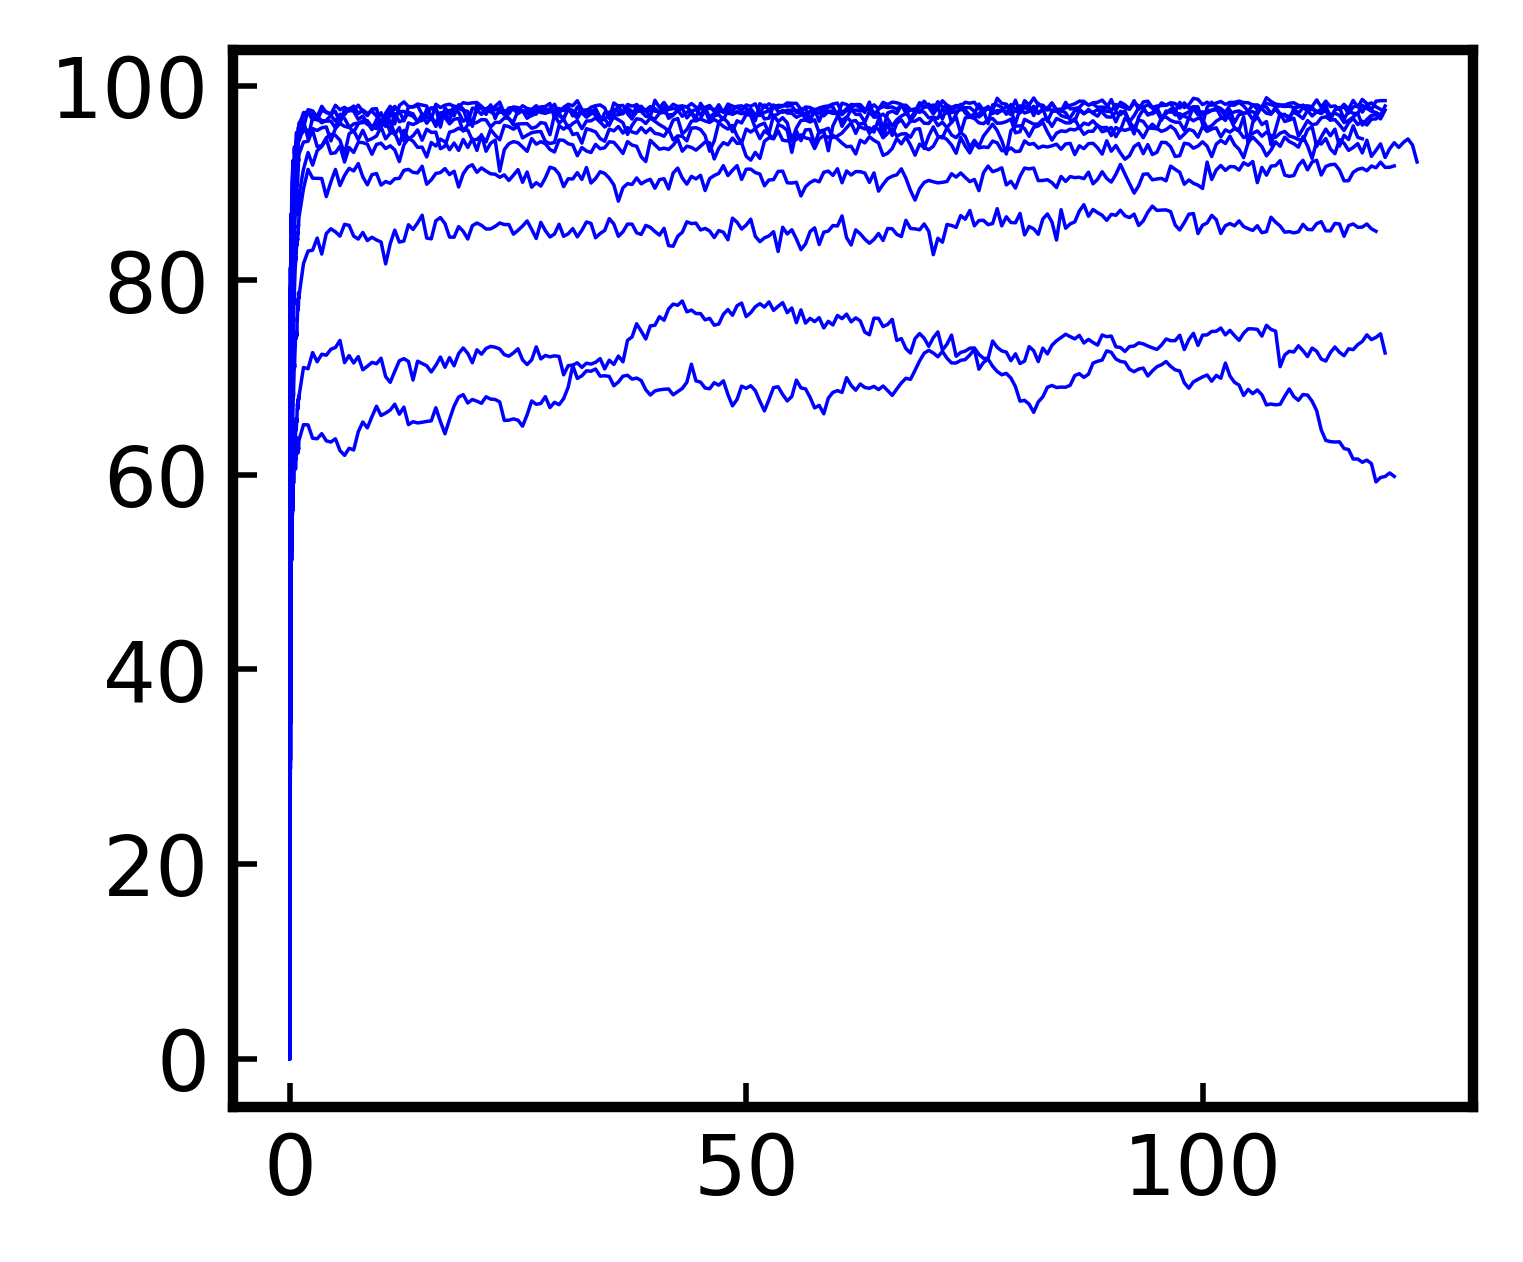

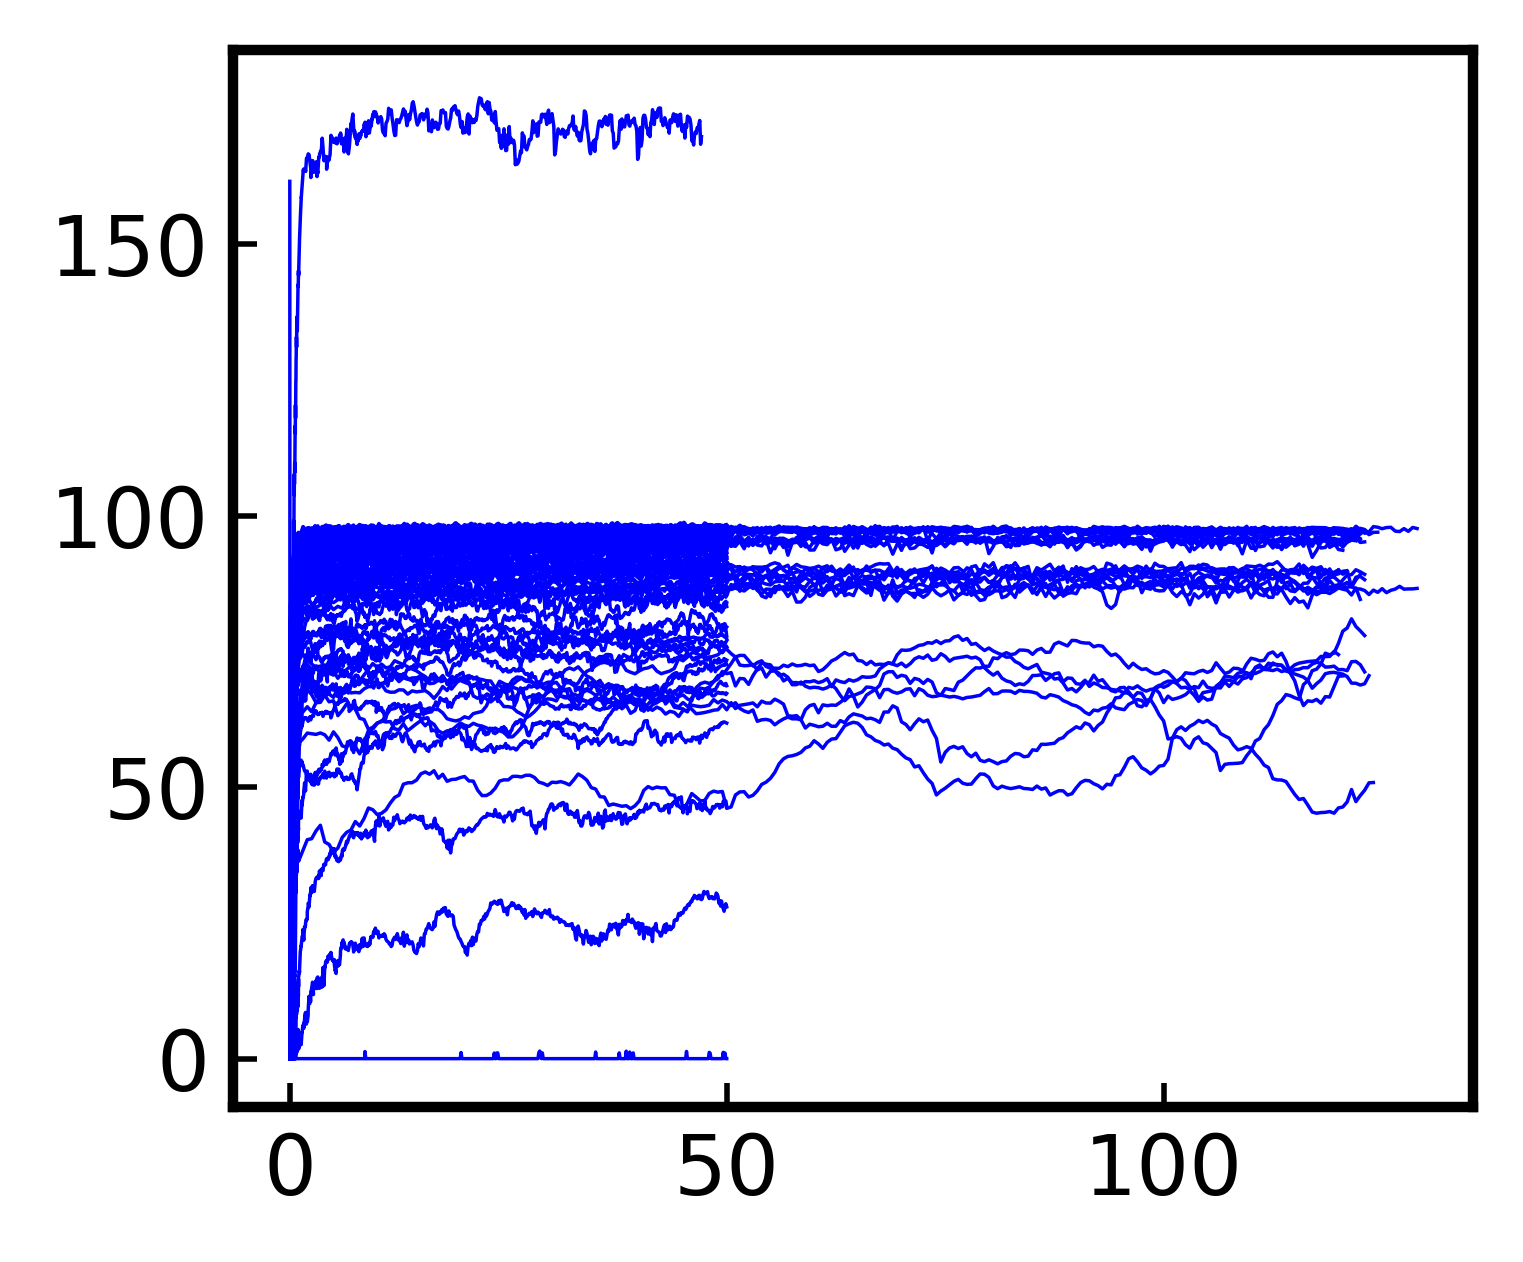

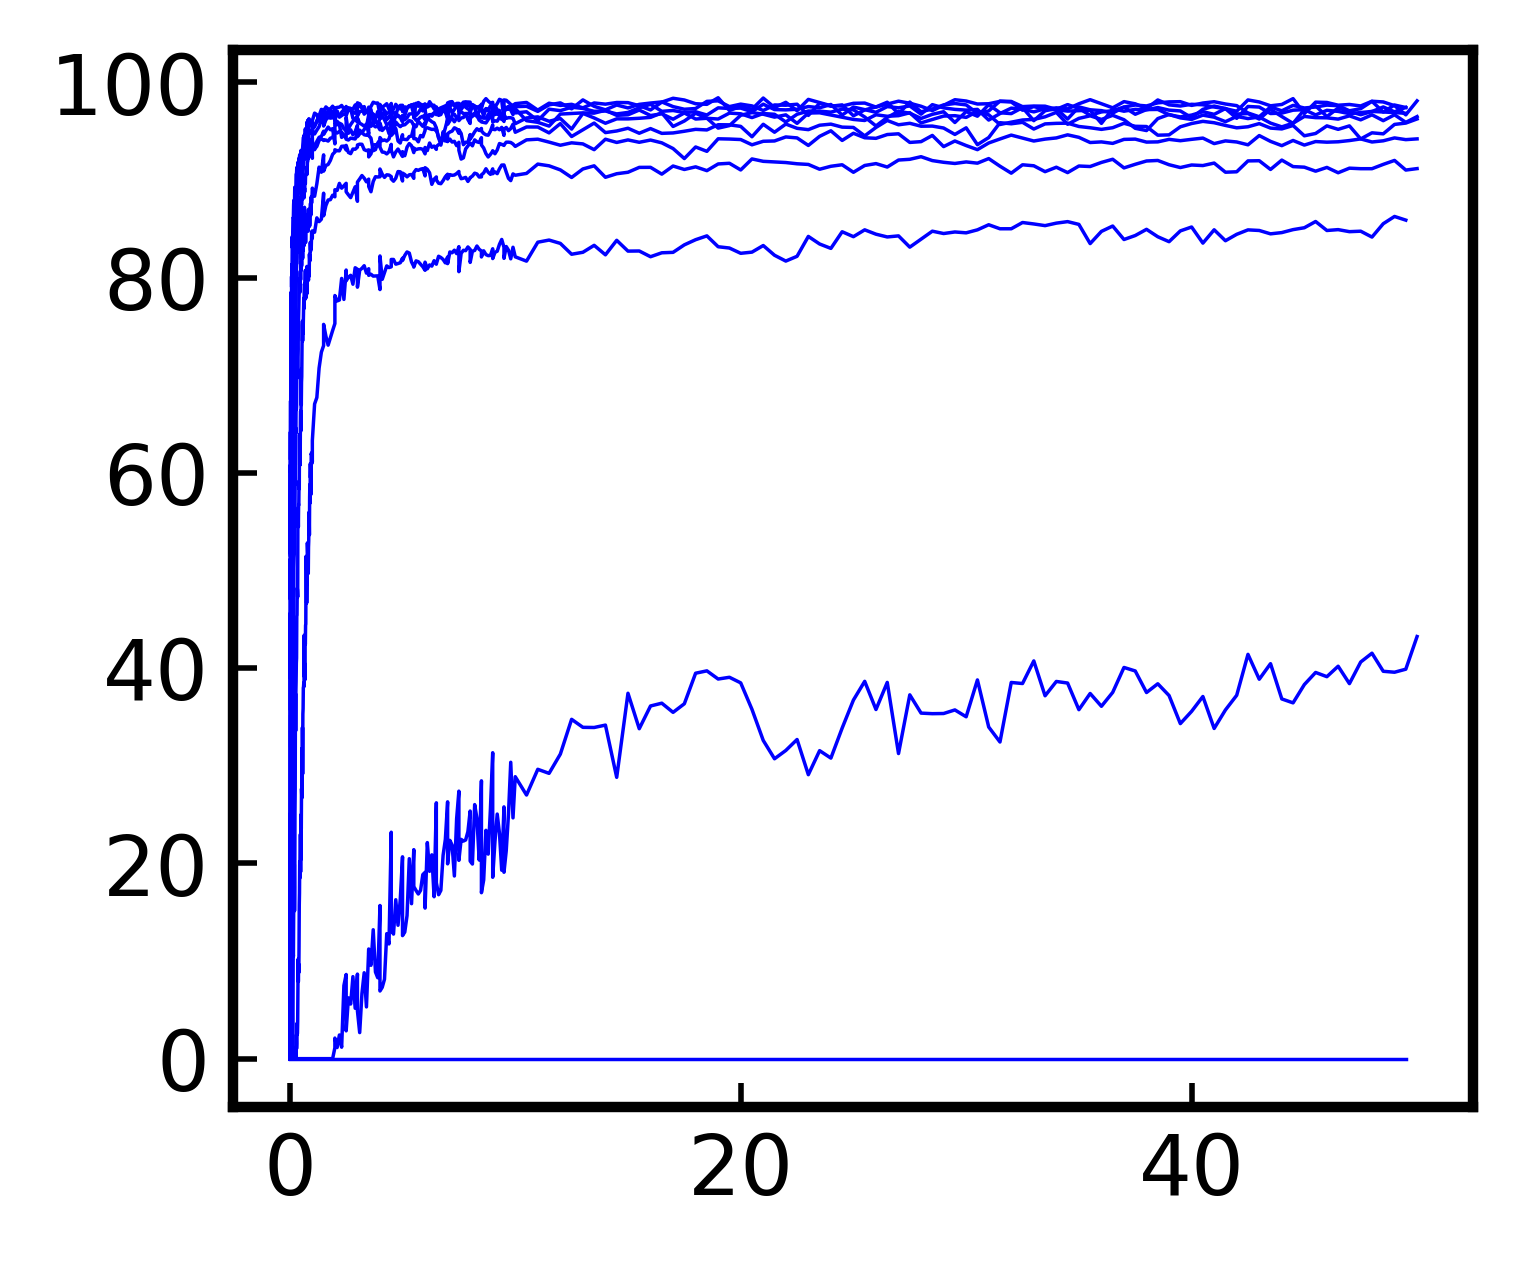

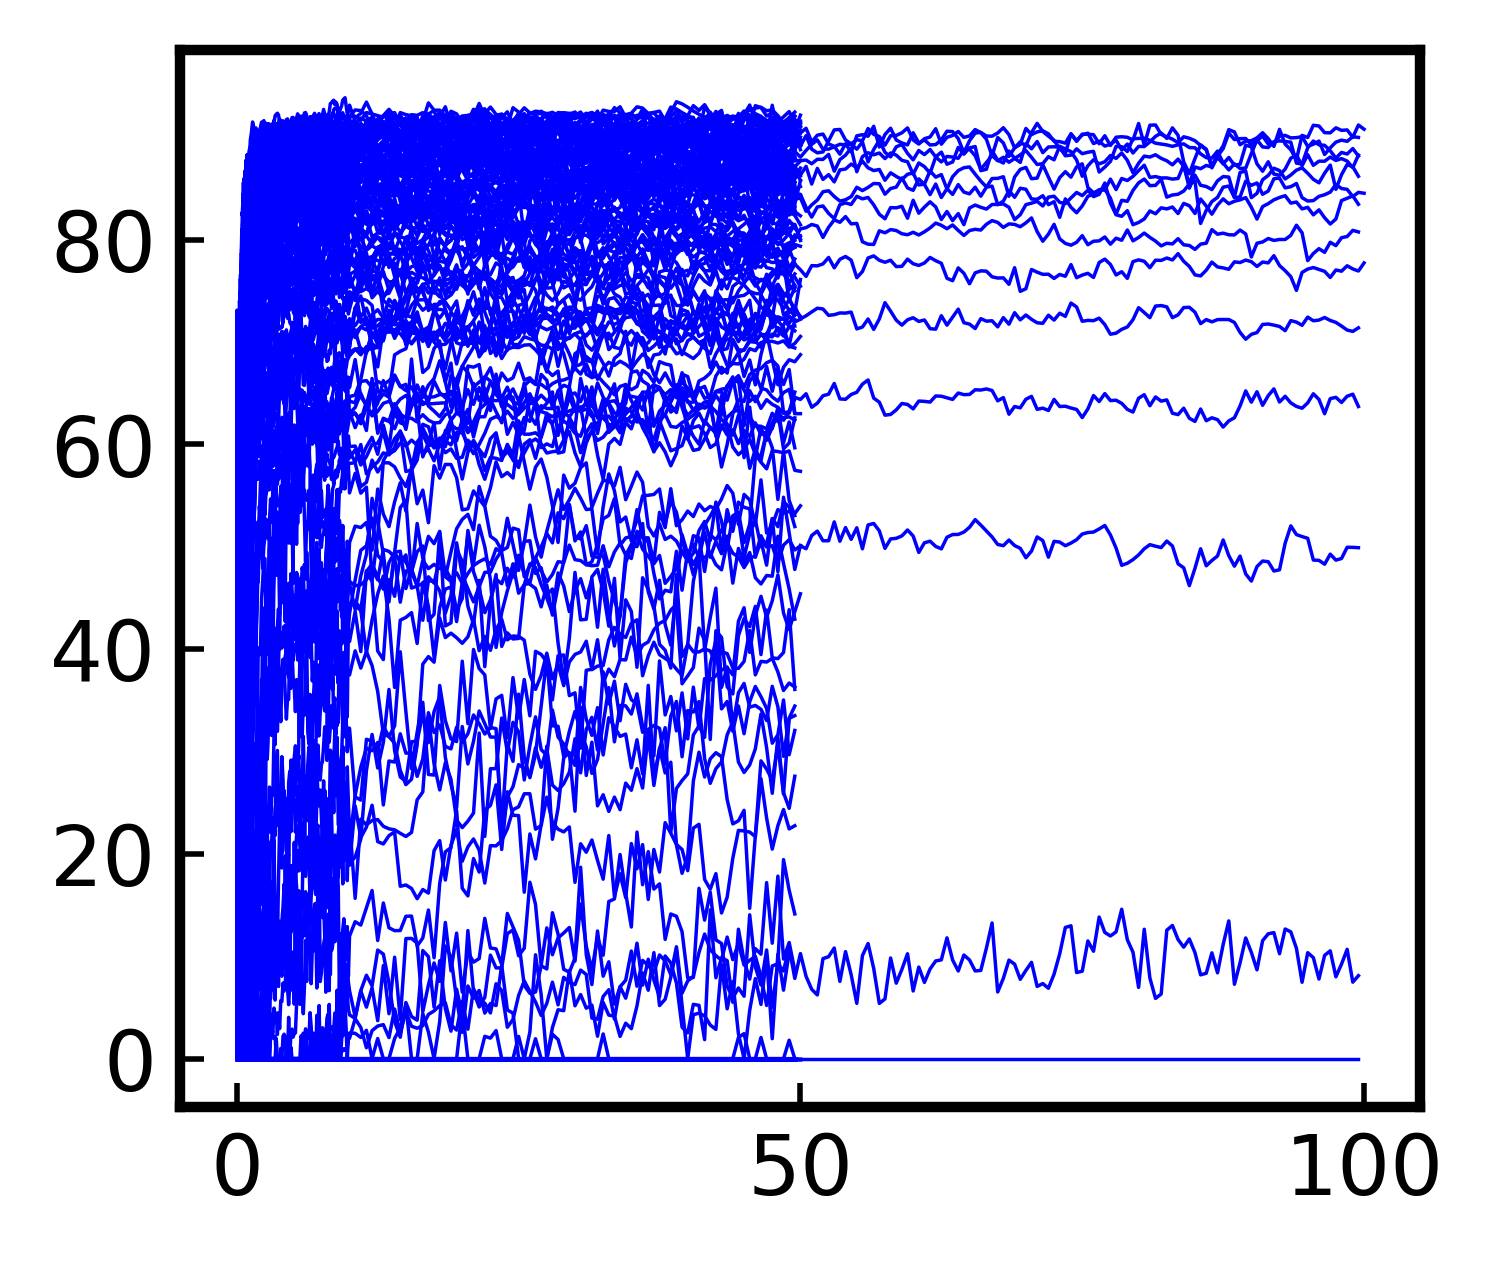

In [11]:
# Make sure I haven't messed up my data
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        plt.plot(all_sims[i][j]['Timestep'][:] / params[i]['brownTime'][j],
                 all_sims[i][j]['Dense_A'][:] / params[i]['partA'][j] * 100.0,
                 c='b',
                 label=str(params[i]['peR'][j]))
    plt.show()

Number of textfiles before delete: 11
Number of all_sims dataframes before delete: 11
Params rows before delete: 11
Number of textfiles after delete: 11
Number of all_sims dataframes after delete: 11
Params rows after delete: 11


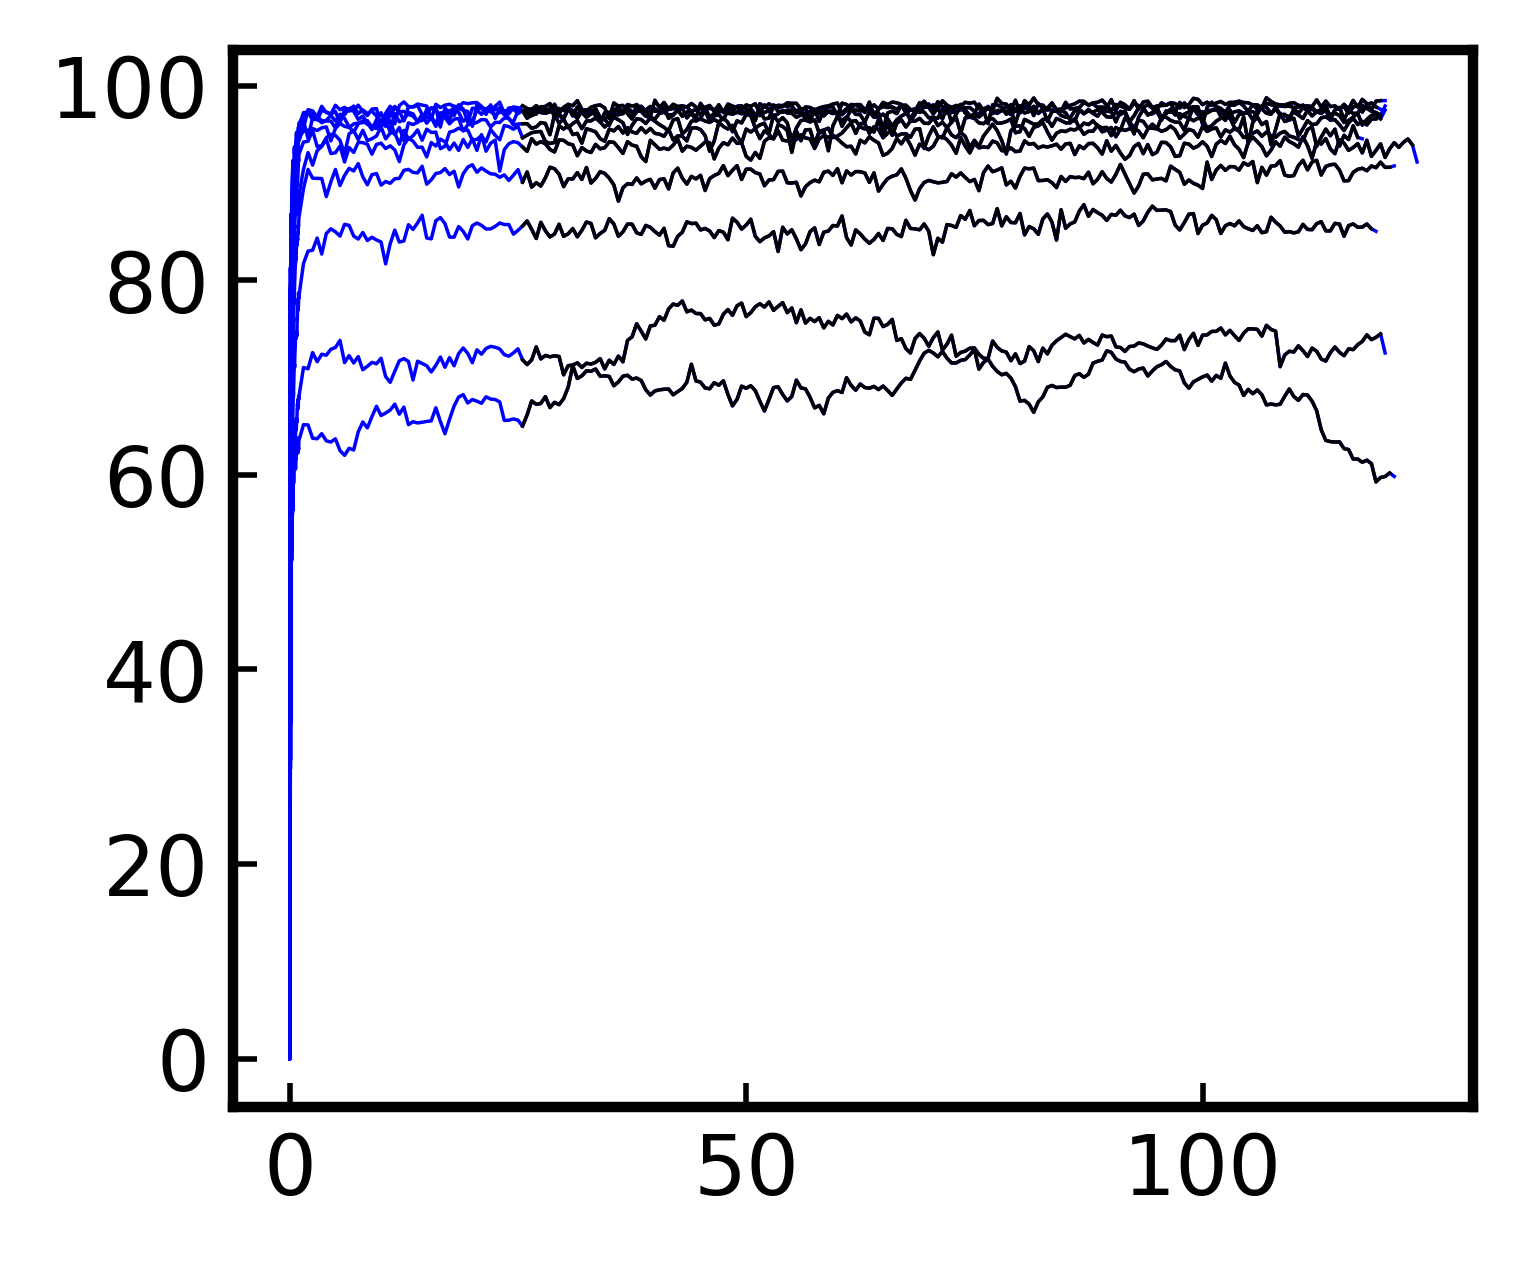

Number of textfiles before delete: 94
Number of all_sims dataframes before delete: 94
Params rows before delete: 94
Number of textfiles after delete: 94
Number of all_sims dataframes after delete: 94
Params rows after delete: 94


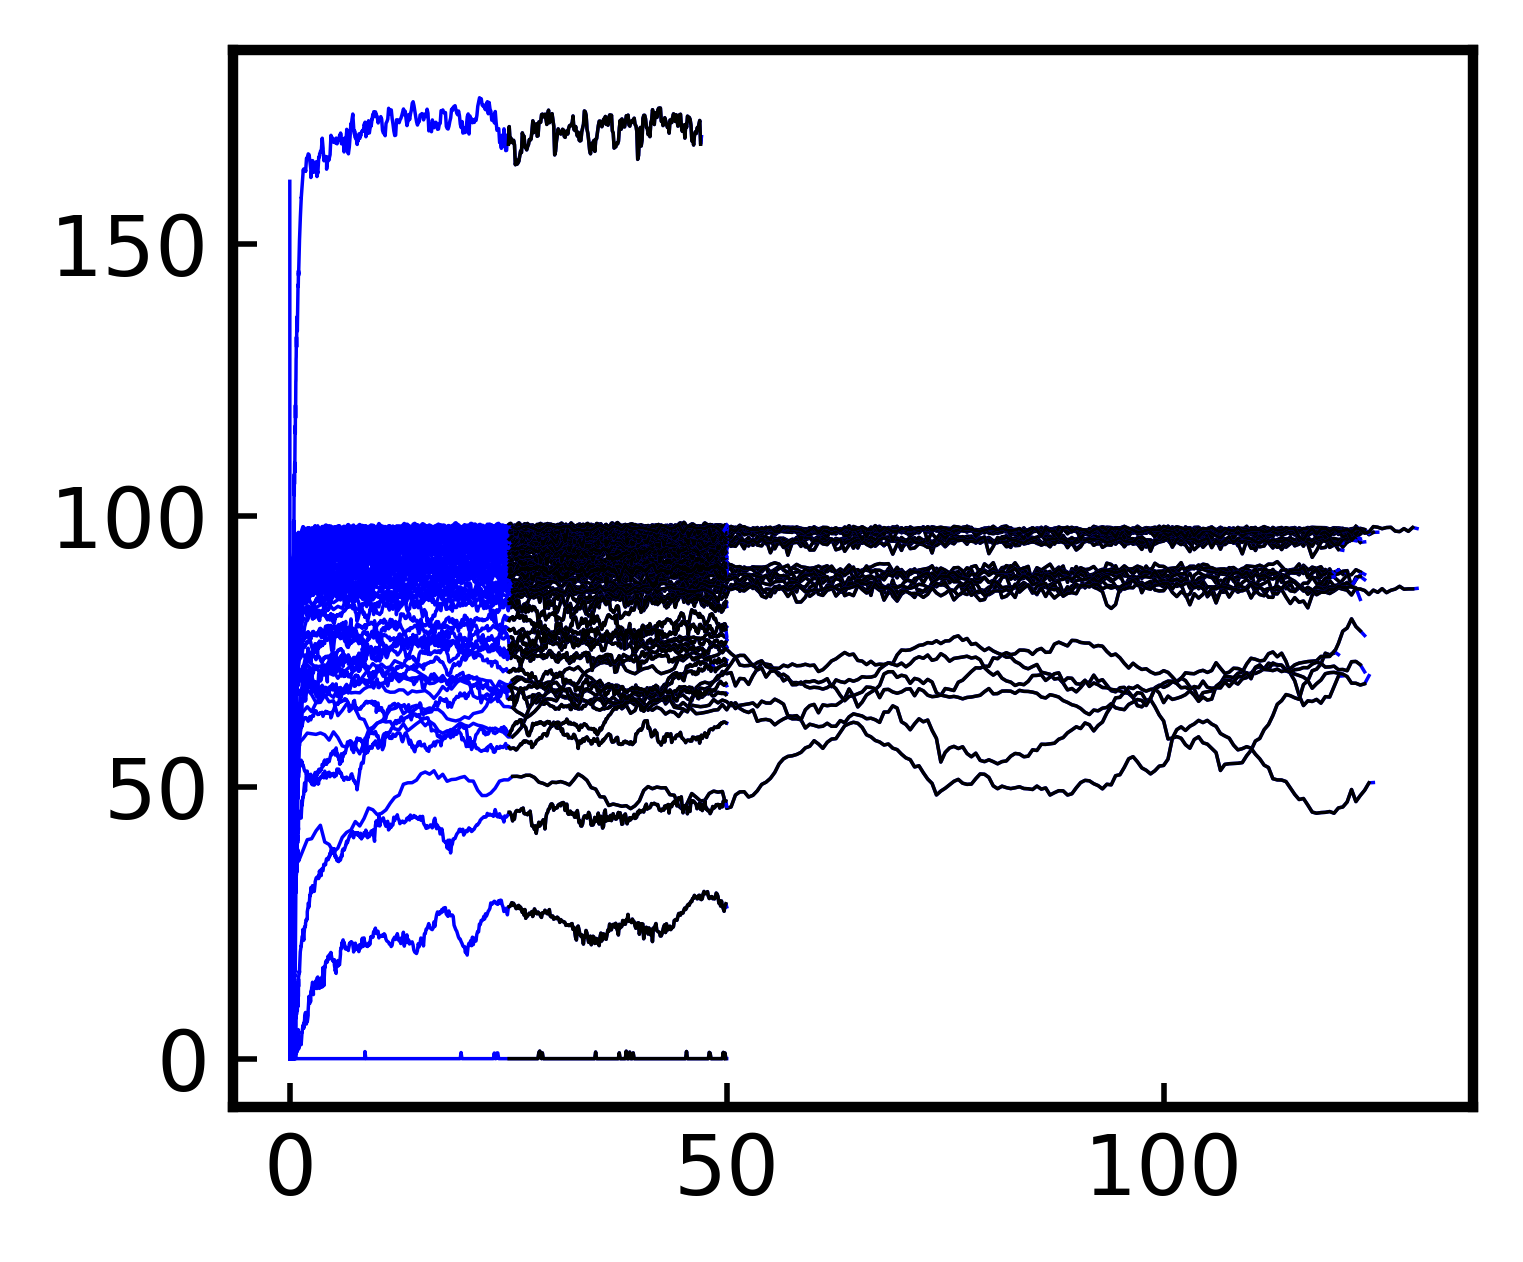

Number of textfiles before delete: 11
Number of all_sims dataframes before delete: 11
Params rows before delete: 11
Number of textfiles after delete: 11
Number of all_sims dataframes after delete: 11
Params rows after delete: 11


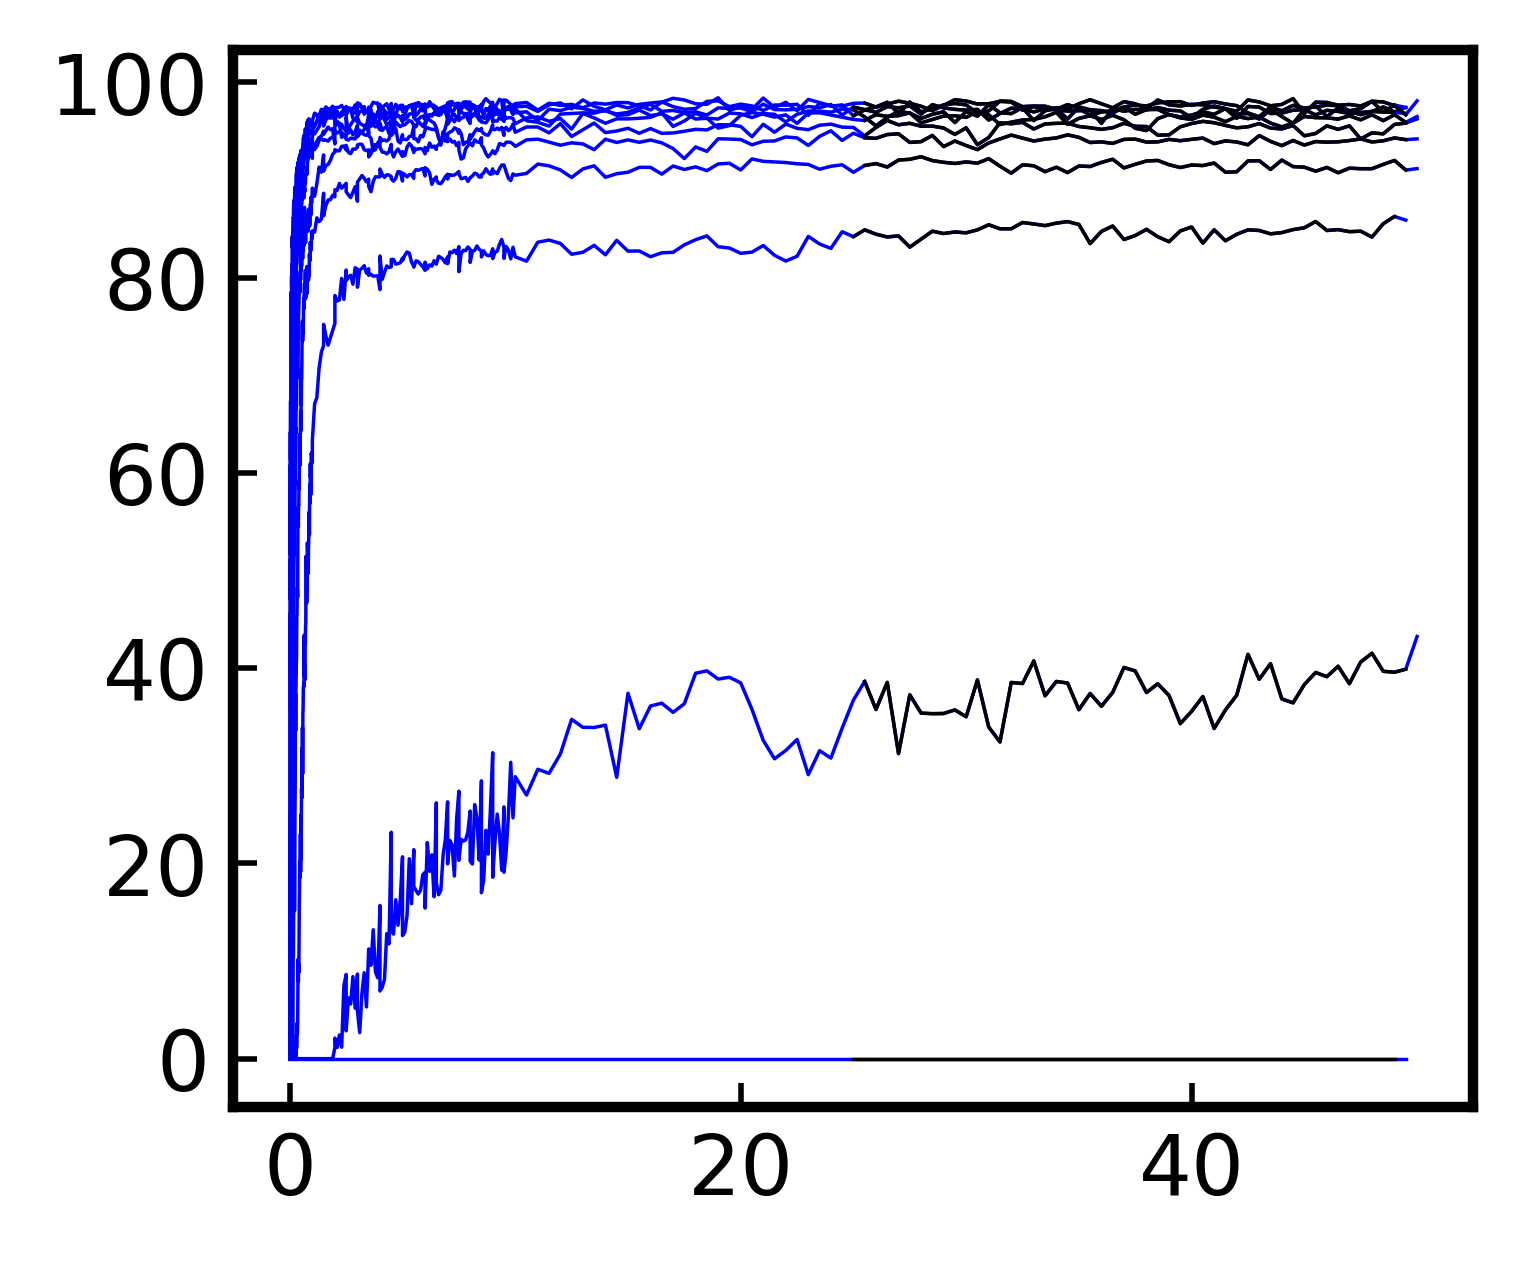

Number of textfiles before delete: 164
Number of all_sims dataframes before delete: 164
Params rows before delete: 164
Number of textfiles after delete: 159
Number of all_sims dataframes after delete: 159
Params rows after delete: 159


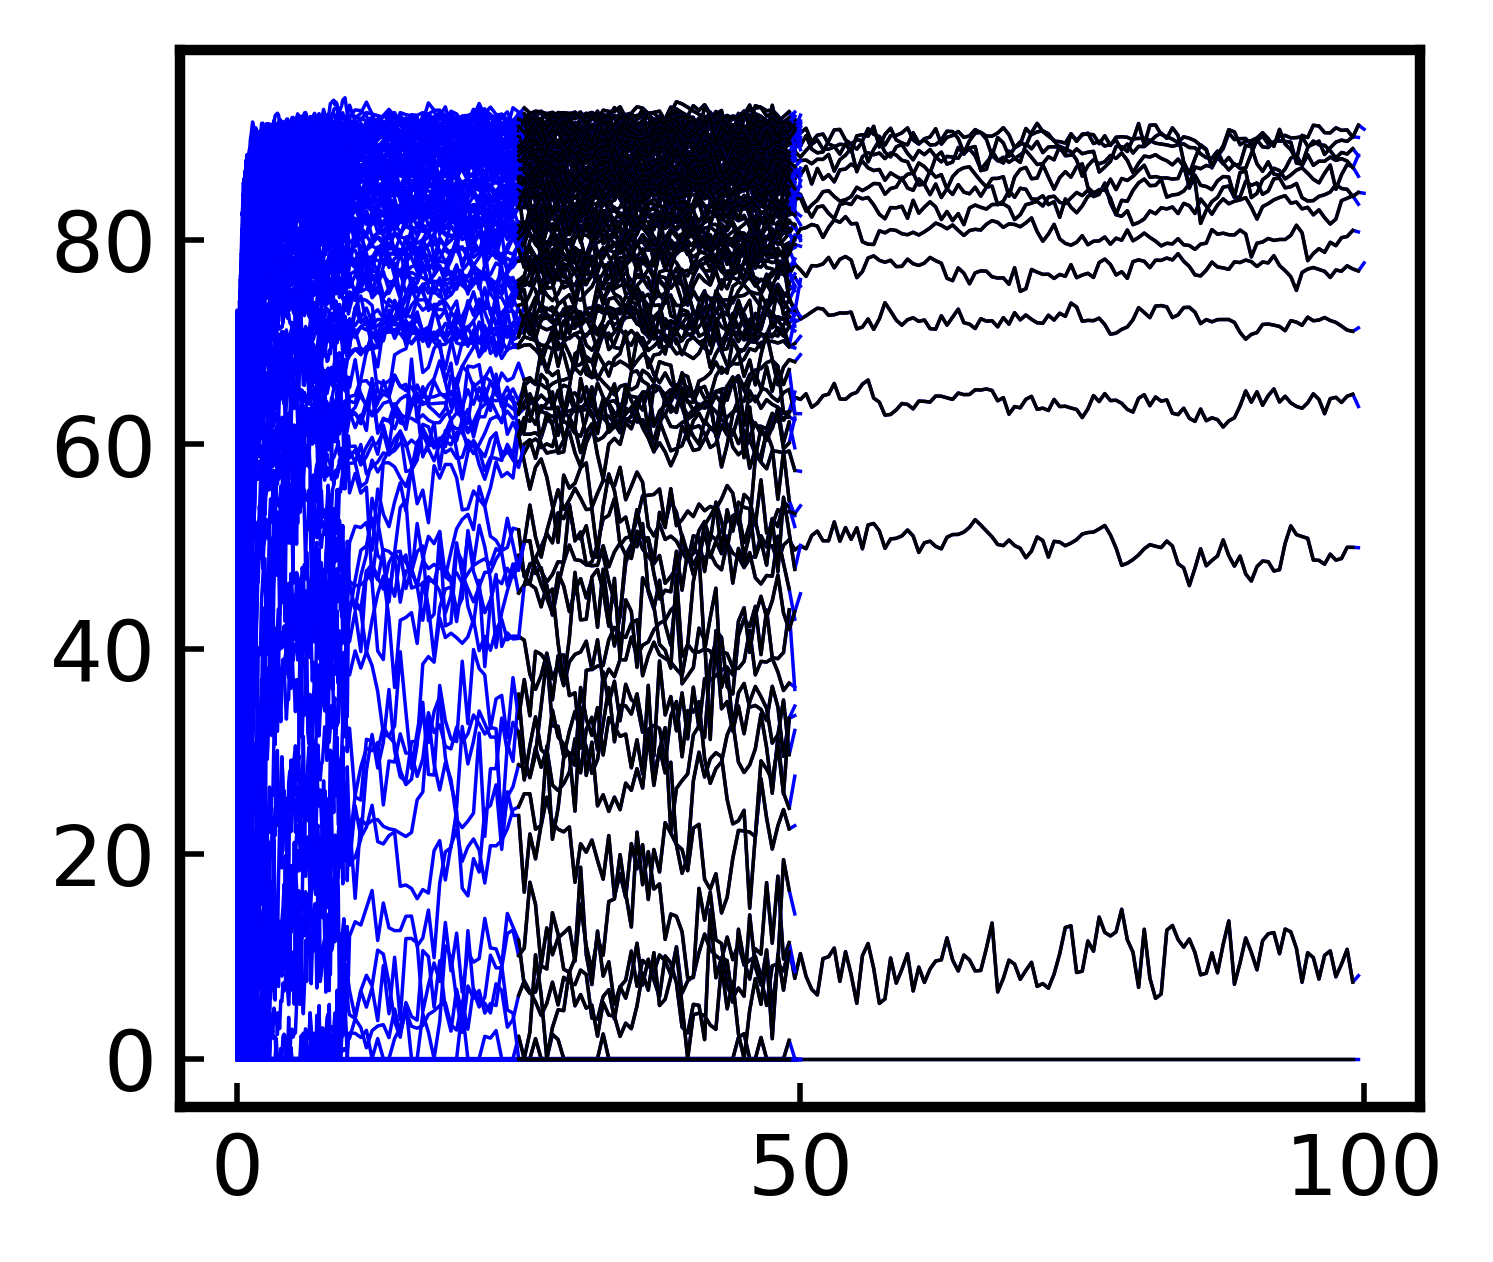

In [12]:
# We should average past a specific time, not an index number...
ssStartTime = 25.0
ssStartInd = [ [] for i in xrange(nSweeps) ]
badFiles = [ [] for i in xrange(nSweeps) ]

# Figure out what we should use for steady-state
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if all_sims[i][j]['Timestep'].iloc[-1] / params[i]['brownTime'][j] >= ssStartTime:
            for k in xrange(len(all_sims[i][j]['Timestep'])):
                if all_sims[i][j]['Timestep'][k] / params[i]['brownTime'][j] >= ssStartTime:
                    ssStartInd[i].append(k)
                    break
        else:
            badFiles[i].append(j)

# Delete rows of dataframe
for i in xrange(nSweeps):
    # Remove these indices from: txtFiles, all_sims, params
    print("Number of textfiles before delete: {}").format(len(fileContainer[i]))
    print("Number of all_sims dataframes before delete: {}").format(len(all_sims[i]))
    print("Params rows before delete: {}").format(len(params[i]['partAll']))
    if badFiles[i]:
        # You have to reverse the order so that you don't mess up your indexing
        for myindex in sorted(badFiles[i], reverse=True):
            del fileContainer[i][myindex]
            del all_sims[i][myindex]
            params[i].drop(params[i].index[myindex], inplace=True)  
    print("Number of textfiles after delete: {}").format(len(fileContainer[i]))
    print("Number of all_sims dataframes after delete: {}").format(len(all_sims[i]))
    print("Params rows after delete: {}").format(len(params[i]['partAll']))

    # You have to reindex the dataframe
    params[i].index = range(len(params[i]['partAll']))

    # Visual check to see if this is the appropriate time window for steady-state
    for j in xrange(len(fileContainer[i])):
        plt.plot(all_sims[i][j]['Timestep'][:] / params[i]['brownTime'][j],
                 all_sims[i][j]['Dense_A'][:] / params[i]['partA'][j] * 100.0,
                 c='b',
                 label=str(params[i]['peR'][j]))
        plt.plot(all_sims[i][j]['Timestep'][ssStartInd[i][j]:-1] / params[i]['brownTime'][j],
                 all_sims[i][j]['Dense_A'][ssStartInd[i][j]:-1] / params[i]['partA'][j] * 100.0,
                 c='k')
    plt.show()

In [13]:
# Get lists for distinct values that I might want to plot

# This is for the activity ratio study
distPeS = []
for j in xrange(len(fileContainer[0])):
    if params[0]['peA'][j] not in distPeS:
        distPeS.append(params[0]['peA'][j])
singleSort(distPeS)
print("{}, PeS: {}").format(sweepName[0], distPeS)

# This is for the particle fraction study
distxA = []
for j in xrange(len(fileContainer[1])):
    if params[1]['xA'][j] not in distxA:
        distxA.append(params[1]['xA'][j])
singleSort(distxA)
print("{}, xS: {}").format(sweepName[1], distxA)

# This is for monodisperse study
distPe = []
for j in xrange(len(fileContainer[2])):
    if params[2]['peA'][j] not in distPe:
        distPe.append(params[2]['peA'][j])
singleSort(distPe)
print("{}, Pe: {}").format(sweepName[2], distPe)

# This is for the constant activity ratio study
distPeR = []
for j in xrange(len(fileContainer[3])):
    if params[3]['peR'][j] not in distPeR:
        distPeR.append(params[3]['peR'][j])
singleSort(distPeR)
print("{}, PeR: {}").format(sweepName[3], distPeR)

Activity Ratio, PeS: [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]
Particle Fraction, xS: [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
Monodisperse, Pe: [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]
Constant Activity Ratio, PeR: [0.1, 0.3, 0.5, 0.7, 0.9]


In [14]:
# Now get time-based steady state values
all_SS = []
all_stdDev = []
all_var = []
for i in xrange(nSweeps):
    # Make list of steady state column headers
    headers = list(all_sims[i][0])
    headers.remove('Timestep')
    SS = pd.DataFrame(columns=headers)
    stdDev = pd.DataFrame(columns=headers)
    var = pd.DataFrame(columns=headers)
    # Initialize dataframes
    for j in xrange(len(fileContainer[i])):
        SS.loc[j] = [0] * len(headers)
        stdDev.loc[j] = [0] * len(headers)
        var.loc[j] = [0] * len(headers)

    # Make dataframe of steady-state data
    for j in xrange(len(fileContainer[i])):
        # Loop through each column (aside from tstep column)
        for k in range(1, len(all_sims[i][j].iloc[1])):
            # Compute mean of data after steady-state time (25tb) in jth column of ith file
            avg = np.mean(all_sims[i][j].iloc[ssStartInd[i][j]:-1, k])
            SS[headers[k-1]][j] = avg
            # Compute the standard deviation and variance in this data
            stdDevor = np.std(all_sims[i][j].iloc[ssStartInd[i][j]:-1, k])
            stdDev[headers[k-1]][j] = stdDevor
            var[headers[k-1]][j] = stdDevor ** 2

    # Normalize by number of particles
    for j in xrange(len(fileContainer[i])):
        if params[i]['partA'][j] != 0:
            SS['Gas_A'][j] /= params[i]['partA'][j]
            SS['Dense_A'][j] /= params[i]['partA'][j]
            SS['Lc_numA'][j] /= params[i]['partA'][j]
            # Now my standard error is a percentage
            stdDev['Gas_A'][j] /= params[i]['partA'][j]
            stdDev['Dense_A'][j] /= params[i]['partA'][j]
            stdDev['Lc_numA'][j] /= params[i]['partA'][j]
            var['Gas_A'][j] /= params[i]['partA'][j]
            var['Dense_A'][j] /= params[i]['partA'][j]
            var['Lc_numA'][j] /= params[i]['partA'][j]

        if params[i]['partB'][j] != 0:
            SS['Gas_B'][j] /= params[i]['partB'][j]
            SS['Dense_B'][j] /= params[i]['partB'][j]
            SS['Lc_numB'][j] /= params[i]['partB'][j]
            stdDev['Gas_B'][j] /= params[i]['partB'][j]
            stdDev['Dense_B'][j] /= params[i]['partB'][j]
            stdDev['Lc_numB'][j] /= params[i]['partB'][j]
            var['Gas_B'][j] /= params[i]['partB'][j]
            var['Dense_B'][j] /= params[i]['partB'][j]
            var['Lc_numB'][j] /= params[i]['partB'][j]

    SS['Gas_tot'][:] /= params[i]['partAll'][:]
    SS['Dense_tot'][:] /= params[i]['partAll'][:] 
    SS['Lg_clust'][:] /= params[i]['partAll'][:] 
    SS['MCS'][:] /= params[i]['partAll'][:]
    stdDev['Gas_tot'][:] /= params[i]['partAll'][:]
    stdDev['Dense_tot'][:] /= params[i]['partAll'][:] 
    stdDev['Lg_clust'][:] /= params[i]['partAll'][:] 
    stdDev['MCS'][:] /= params[i]['partAll'][:]
    var['Gas_tot'][:] /= params[i]['partAll'][:]
    var['Dense_tot'][:] /= params[i]['partAll'][:] 
    var['Lg_clust'][:] /= params[i]['partAll'][:] 
    var['MCS'][:] /= params[i]['partAll'][:]

    SS['Gas_A'][:] *= 100.0
    SS['Gas_B'][:] *= 100.0
    SS['Gas_tot'][:] *= 100.0
    SS['Dense_A'][:] *= 100.0
    SS['Dense_B'][:] *= 100.0
    SS['Dense_tot'][:] *= 100.0
    SS['Lc_numA'][:] *= 100.0
    SS['Lc_numB'][:] *= 100.0
    SS['Lg_clust'][:] *= 100.0
    SS['MCS'][:] *= 100.0
    stdDev['Gas_A'][:] *= 100.0
    stdDev['Gas_B'][:] *= 100.0
    stdDev['Gas_tot'][:] *= 100.0
    stdDev['Dense_A'][:] *= 100.0
    stdDev['Dense_B'][:] *= 100.0
    stdDev['Dense_tot'][:] *= 100.0
    stdDev['Lc_numA'][:] *= 100.0
    stdDev['Lc_numB'][:] *= 100.0
    stdDev['Lg_clust'][:] *= 100.0
    stdDev['MCS'][:] *= 100.0
    var['Gas_A'][:] *= 100.0
    var['Gas_B'][:] *= 100.0
    var['Gas_tot'][:] *= 100.0
    var['Dense_A'][:] *= 100.0
    var['Dense_B'][:] *= 100.0
    var['Dense_tot'][:] *= 100.0
    var['Lc_numA'][:] *= 100.0
    var['Lc_numB'][:] *= 100.0
    var['Lg_clust'][:] *= 100.0
    var['MCS'][:] *= 100.0
    
    # Put these values into the modular container
    all_SS.append(SS)
    all_stdDev.append(stdDev)
    all_var.append(var)
    # Delete these and loop through next parameter sweep
    del SS
    del stdDev
    del var
    
pd.set_option('display.max_rows', 6)
display(all_SS[0])

Gas_A    Gas_B  Gas_tot  Dense_A  Dense_B Dense_tot  Lc_numA  Lc_numB  \
0   31.2066  5.41386  18.3102  68.7934  94.5861   81.6898  67.8256  93.4688   
1    25.911  4.60346  15.2572   74.089  95.3965   84.7428  73.1968  94.4661   
2   14.5316  3.39866  8.96513  85.4684  96.6013   91.0349   85.027  96.1805   
..      ...      ...      ...      ...      ...       ...      ...      ...   
8   2.74884  2.17313  2.46098  97.2512  97.8269    97.539  97.0824   97.666   
9   2.31587  2.05718  2.18653  97.6841  97.9428   97.8135  97.6242  97.8851   
10  2.07494  2.07651  2.07572  97.9251  97.9235   97.9243  97.8609  97.8592   

   Lg_clust      MCS   ...       sigAA    sigAB    sigBB phiEff lg_clustA  \
0   80.6472  69.3523   ...     1.00029  1.00025  1.00023    0.6   63372.6   
1   83.8314  74.0742   ...     1.00032  1.00028  1.00028    0.6   65880.6   
2   90.6037  80.6533   ...     1.00034   1.0003  1.00027    0.6   71203.4   
..      ...      ...   ...         ...      ...      ...    ...       ...   
8   97.3742  93.6702   ...     1.00013  1.00013  1.00013    0.6   76497.2   
9   97.7547  96.2603   ...     1.00011  1.00009  1.00009    0.6   76791.2   
10    97.86  96.3718   ...     1.00004  1.00005  1.00006    0.6   76866.9   

   tot_clustA LC_density DP_density GP_density   nClust  
0     64191.9       1.27       1.27   0.273979  1.32461  
1     66596.8       1.27       1.27    0.23746  1.26985  
2     71542.2       1.27       1.27   0.150909   1.2353  
..        ...        ...        ...        ...      ...  
8     76626.7       1.27       1.27  0.0451323  1.07937  
9     76837.4       1.27       1.27  0.0405319  1.03192  
10    76917.3       1.27       1.27  0.0387302  1.03175  

[11 rows x 21 columns]

In [15]:
# Okay, now we have all of our data wrangled, we can plot it
from collections import OrderedDict

myCols = ['#26284A',
          '#01545B',
          '#017351',
          '#02C383',
          '#AAD962',
          '#FABF45',
          '#EF6A32',
          '#ED0245',
          '#A1295E',
          '#700161',
          'k']

myShps = ['o',
          '^',
          's',
          'D',
          'P',
          'X',
          '*',
          '<']

def getCol(peR):
    index = int(peR * 10) - 1
    return myCols[index]

# def pesToCol(peS):
#     index = 

def getShp(xA):
    index = int(xA / 10)
    return myShps[index]

In [16]:
# Okay now we can plot things :)

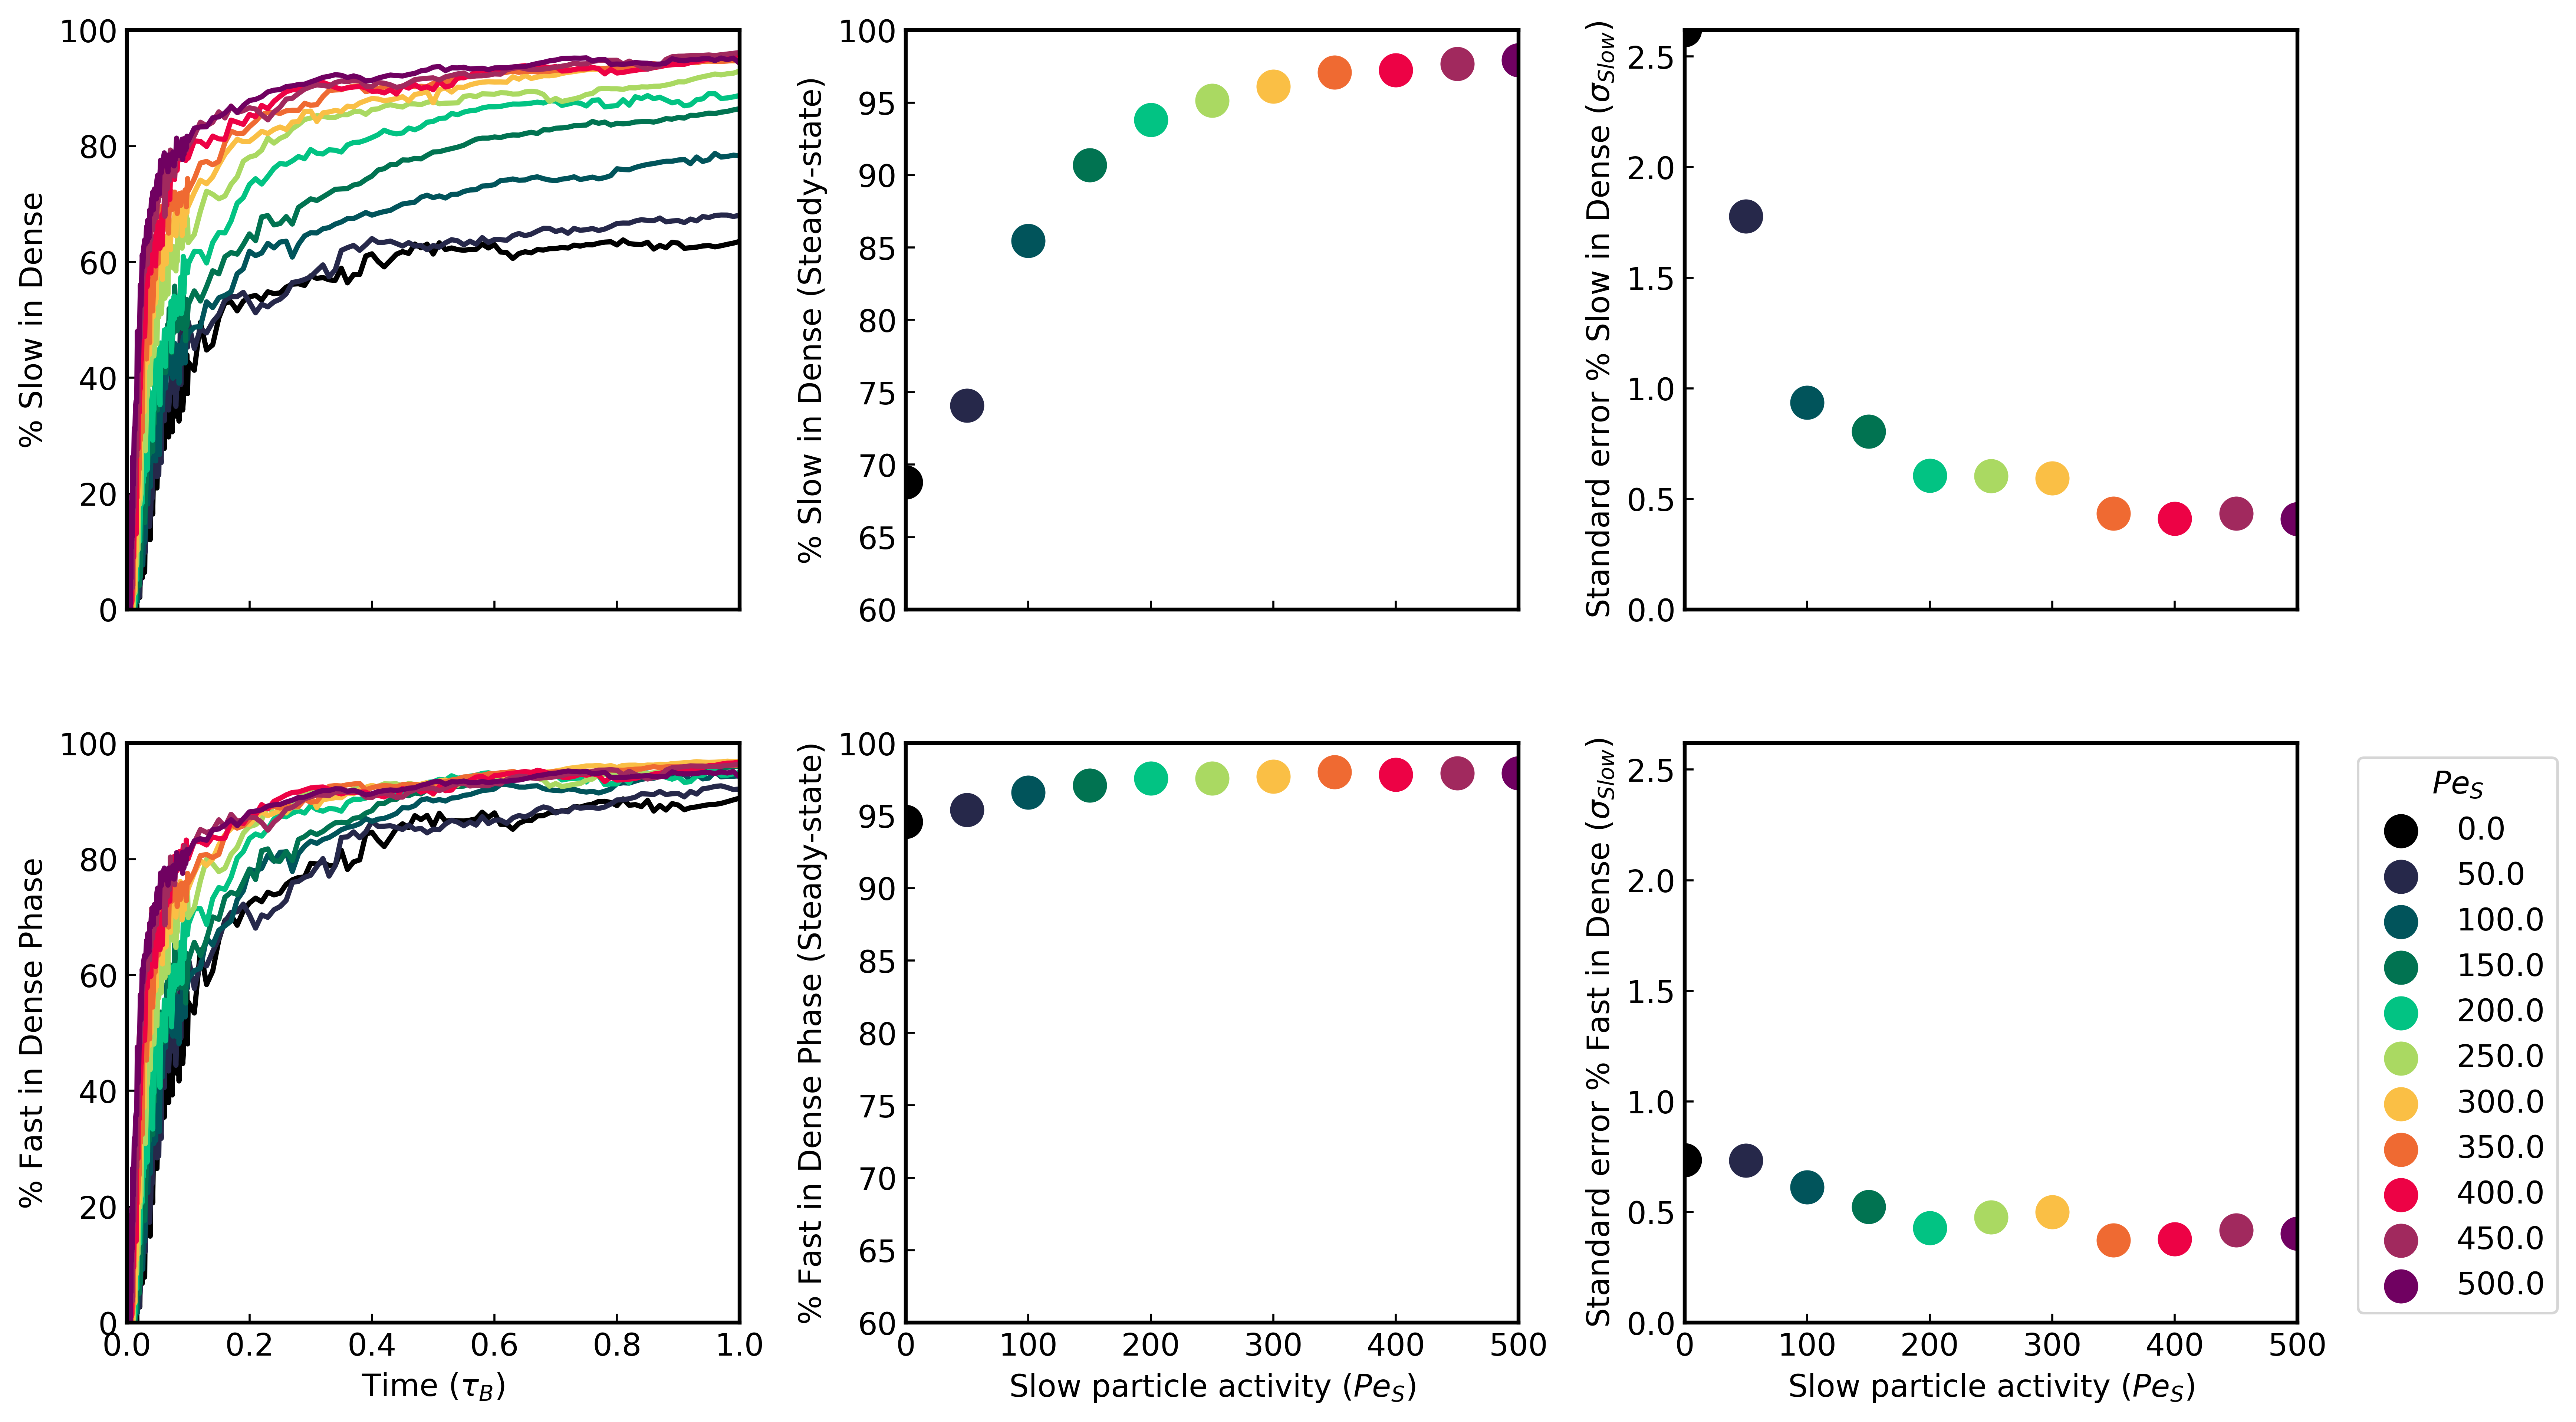

In [17]:
# Line width
mylw = 2.0
# Marker size
mysz = 150.0
# Sweep to look at
swp = 0
# List of distinct variables
var = distPeS
# Variable name
varName = 'peA'
# Hold variable constant
constName = 'xA'
constVal = 50

##############################
### All for slow particles ###
##############################

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
# First row constant particle fraction (xA = 50), activity ratio study
for i in xrange(len(fileContainer[swp])):
    # Hold particle fraction constant
    if params[swp][constName][i] == constVal:
        # This is 1tauB data
        ax[0][0].plot(all_sims[swp][i]['Timestep'] / params[swp]['brownTime'][i],
                   all_sims[swp][i]['Dense_A'] / params[swp]['partA'][i] * 100.0,
                   label=params[swp][varName][i],
                   lw=mylw,
                   c=getCol(params[swp][varName][i] / max(var))
                  )
        # This is SS data
        ax[0][1].scatter(params[swp][varName][i],
                      all_SS[swp]['Dense_A'][i],
                      label=params[swp][varName][i],
                      s=mysz,
                      c=getCol(params[swp][varName][i] / max(var))
                     )

        # This is standard error data
        ax[0][2].scatter(params[swp][varName][i],
                      all_stdDev[swp]['Dense_A'][i],
                      label=params[swp][varName][i],
                      s=mysz,
                      c=getCol(params[swp][varName][i] / max(var))
                     )

# Settings for 1tauB data
ax[0][0].set_xlim(0, 1.0)
# ax[0][0].set_xlabel(r'Time $(\tau_{B})$')
# ax[0][0].set_xticks([])
labels = [item.get_text() for item in ax[0][0].get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax[0][0].set_xticklabels(empty_string_labels)
ax[0][0].set_ylim(0, 100.0)
ax[0][0].set_ylabel(r'% Slow in Dense')

# Settings for SS data
ax[0][1].set_xlim(0, max(var))
# ax[0][1].set_xlabel(r'Slow particle activity $(Pe_{S})$')
# ax[0][1].set_xticks([])
labels = [item.get_text() for item in ax[0][1].get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax[0][1].set_xticklabels(empty_string_labels)
ax[0][1].set_ylim(60.0, 100.0)
ax[0][1].set_ylabel(r'% Slow in Dense (Steady-state)')
    
# Settings for standard error data
ax[0][2].set_xlim(0, max(var))
# ax[0][2].set_xlabel(r'Slow particle activity $(Pe_{S})$')
# ax[0][2].set_xticks([])
labels = [item.get_text() for item in ax[0][2].get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax[0][2].set_xticklabels(empty_string_labels)
ax[0][2].set_ylim(0, max(all_stdDev[swp]['Dense_A'][:]))
ax[0][2].set_ylabel(r'Standard error % Slow in Dense $(\sigma_{Slow})$')

# Legend details
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax[0][2].legend(by_label.values(), by_label.keys(), title=r'$Pe_{S}$', loc = 4, bbox_to_anchor=(1.55, -0.085))

###############################
### Same for fast particles ###
###############################

# fig, ax = plt.subplots(1, 3, figsize=(14, 4))
# First row constant particle fraction (xA = 50), activity ratio study
for i in xrange(len(fileContainer[swp])):
    # Hold particle fraction constant
    if params[swp][constName][i] == constVal:
        # This is 1tauB data
        ax[1][0].plot(all_sims[swp][i]['Timestep'] / params[swp]['brownTime'][i],
                   all_sims[swp][i]['Dense_B'] / params[swp]['partB'][i] * 100.0,
                   label=params[swp][varName][i],
                   lw=mylw,
                   c=getCol(params[swp][varName][i] / max(var))
                  )
        # This is SS data
        ax[1][1].scatter(params[swp][varName][i],
                      all_SS[swp]['Dense_B'][i],
                      label=params[swp][varName][i],
                      s=mysz,
                      c=getCol(params[swp][varName][i] / max(var))
                     )

        # This is standard error data
        ax[1][2].scatter(params[swp][varName][i],
                      all_stdDev[swp]['Dense_B'][i],
                      label=params[swp][varName][i],
                      s=mysz,
                      c=getCol(params[swp][varName][i] / max(var))
                     )

# Settings for 1tauB data
ax[1][0].set_xlim(0, 1.0)
ax[1][0].set_xlabel(r'Time $(\tau_{B})$')
ax[1][0].set_ylim(0, 100.0)
ax[1][0].set_ylabel(r'% Fast in Dense Phase')

# Settings for SS data
ax[1][1].set_xlim(0, max(var))
ax[1][1].set_xlabel(r'Slow particle activity $(Pe_{S})$')
ax[1][1].set_ylim(60.0, 100.0)
ax[1][1].set_ylabel(r'% Fast in Dense Phase (Steady-state)')
    
# Settings for standard error data
ax[1][2].set_xlim(0, max(var))
ax[1][2].set_xlabel(r'Slow particle activity $(Pe_{S})$')
ax[1][2].set_ylim(0, max(all_stdDev[swp]['Dense_A'][:]))
ax[1][2].set_ylabel(r'Standard error % Fast in Dense $(\sigma_{Slow})$')

# Legend details
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[1][2].legend(by_label.values(), by_label.keys(),
                title=r'$Pe_{S}$', loc = 4, bbox_to_anchor=(1.45, -0.01))

plt.tight_layout()
plt.show()

# Second row constant activity
plt.close()


[0.0, 50.0, 100.0, 125.0, 150.0, 200.0, 250.0, 300.0, 350.0, 375.0, 400.0, 450.0]


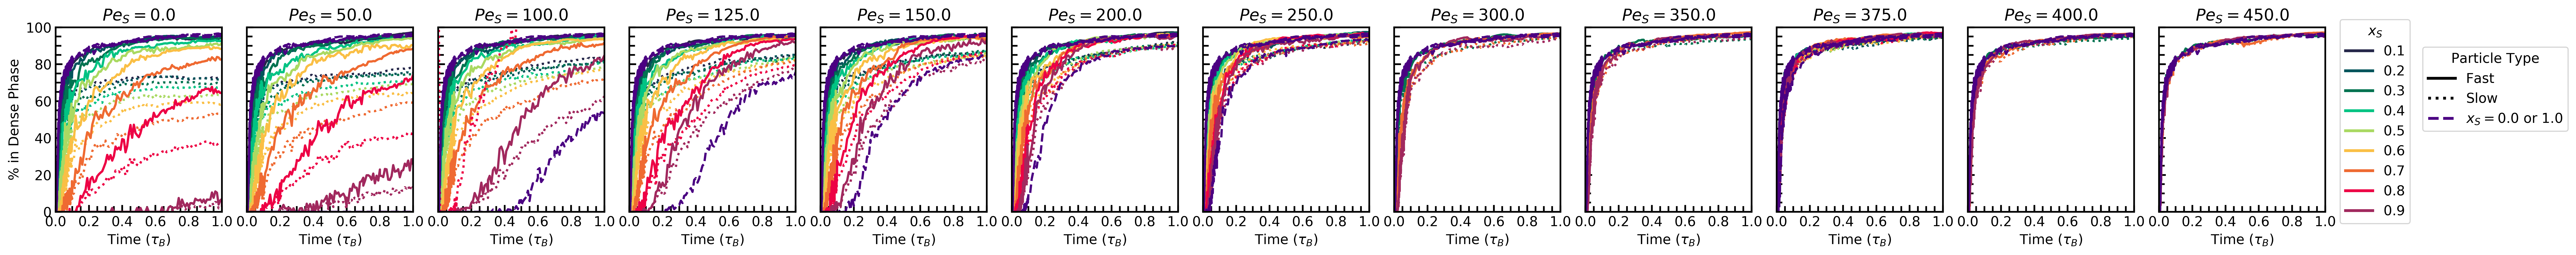

In [38]:
# Let's get the PeS values for the xS study
PeSinxS = []
for i in xrange(len(fileContainer[1])):
    if params[1]['peA'][i] not in PeSinxS:
        PeSinxS.append(params[1]['peA'][i])
PeSinxS.remove(500)
print(PeSinxS)

# # Overlay the fast and slow data for the particle fraction study
figLength = len(PeSinxS)
scale = 3
fig, ax = plt.subplots(1, figLength, figsize=(figLength*scale, 1*scale))
for i in xrange(len(PeSinxS)):
    for j in xrange(len(fileContainer[1])):
        if params[1]['peA'][j] == 500:
            ax[i].plot(all_sims[1][j]['Timestep'] / params[1]['brownTime'][j],
                           all_sims[1][j]['Dense_A'] / params[1]['partA'][j] * 100.0,
                           linestyle='--',
                           label=0.0,
                           lw=mylw,
                           c='#4B0082'
                          )
        if params[1]['peA'][j] == PeSinxS[i]:
            # Monodisperse
            if params[1]['xA'][j] == 100.0:
                ax[i].plot(all_sims[1][j]['Timestep'] / params[1]['brownTime'][j],
                           all_sims[1][j]['Dense_A'] / params[1]['partA'][j] * 100.0,
                           linestyle='--',
                           label=1.0,
                           lw=mylw,
                           c='#4B0082'
                          )
            else:
                ax[i].plot(all_sims[1][j]['Timestep'] / params[1]['brownTime'][j],
                           all_sims[1][j]['Dense_A'] / params[1]['partA'][j] * 100.0,
                           label=params[1]['xA'][j] / 100.0,
                           linestyle=':',
                           lw=mylw,
                           c=getCol(params[1]['xA'][j] / max(distxA))
                          )
                ax[i].plot(all_sims[1][j]['Timestep'] / params[1]['brownTime'][j],
                           all_sims[1][j]['Dense_B'] / params[1]['partB'][j] * 100.0,
                           label=params[1]['xA'][j] / 100.0,
                           linestyle='-',
                           lw=mylw,
                           c=getCol(params[1]['xA'][j] / max(distxA))
                          )
                ax[i].set_xlim(0, 1.0)
                ax[i].set_ylim(0, 100.0)
                ax[i].set_title(r'$Pe_{S}=$' + str(PeSinxS[i]))
                ax[i].set_xlabel(r'Time $(\tau_{B})$')
                
                # I can set all my ticks in this loop
                ax[i].xaxis.set_major_locator(MultipleLocator(0.2))
                ax[i].xaxis.set_minor_locator(MultipleLocator(0.05))
                ax[i].yaxis.set_major_locator(MultipleLocator(20))
                ax[i].yaxis.set_minor_locator(MultipleLocator(5))
                
                ax[i].tick_params(which='major', length=6, width = 1.5)
                ax[i].tick_params(which='minor', length=5, width = 1.5)
                
                if i > 0:
                    ax[i].tick_params(labelleft=False)
                
ax[0].set_ylabel('% in Dense Phase')

# Legend for line color (particle fraction)
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax[3].legend(by_label.values(), by_label.keys(),
#              title=r'$x_{S}$', loc = 4, bbox_to_anchor=(1.35, -0.015))

# Legend for particle type
leglw = 2.5
legend_elements = [Line2D([0], [0], color=myCols[0], lw=leglw, label=r'$0.1$'),
                   Line2D([0], [0], color=myCols[1], lw=leglw, label=r'$0.2$'),
                   Line2D([0], [0], color=myCols[2], lw=leglw, label=r'$0.3$'),
                   Line2D([0], [0], color=myCols[3], lw=leglw, label=r'$0.4$'),
                   Line2D([0], [0], color=myCols[4], lw=leglw, label=r'$0.5$'),
                   Line2D([0], [0], color=myCols[5], lw=leglw, label=r'$0.6$'),
                   Line2D([0], [0], color=myCols[6], lw=leglw, label=r'$0.7$'),
                   Line2D([0], [0], color=myCols[7], lw=leglw, label=r'$0.8$'),
                   Line2D([0], [0], color=myCols[8], lw=leglw, label=r'$0.9$'),
                  ]
leg2 = [Line2D([0], [0], color='k', lw=leglw, linestyle='-', label=r'Fast'),
        Line2D([0], [0], color='k', lw=leglw, linestyle=':', label=r'Slow'),
        Line2D([0], [0], color='#4B0082', lw=leglw, linestyle='--', label=r'$x_{S}=0.0$ or $1.0$')
       ]
colLeg = ax[-1].legend(title=r'$x_{S}$', handles=legend_elements, loc = 4, 
                      bbox_to_anchor=(1.55, -0.1))
ax[-1].legend(title=r'Particle Type', handles=leg2, loc = 4, 
             bbox_to_anchor=(2.5, 0.4))
ax[-1].add_artist(colLeg)

plt.subplots_adjust(wspace=0.15)
plt.savefig('particle_fraction_vs_time.pdf', dpi=1000, bbox_inches = 'tight',
    pad_inches = 0)

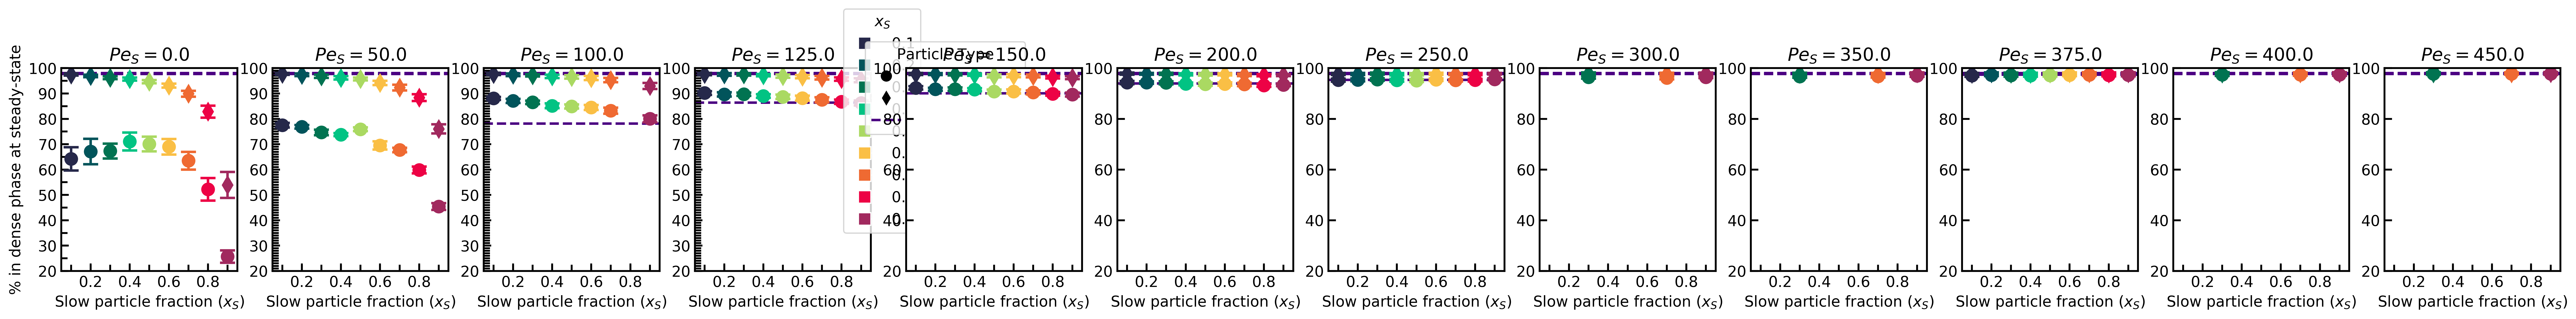

In [44]:
# Here I'll plot the steady state values (both fast and slow) with std dev overlayed
mysz = 10
# Overlay the fast and slow data for the particle fraction study
figLength = len(PeSinxS)
scale = 3
fig, ax = plt.subplots(1, figLength, figsize=(figLength*scale, 1*scale))
for i in xrange(len(PeSinxS)):
    for j in xrange(len(fileContainer[1])):
        if params[1]['peA'][j] == 500:
            ax[i].axhline(y = all_SS[1]['Dense_A'][j],
                          linestyle='--',
                          label=0.0,
                          lw=mylw,
                          c='#4B0082',
                          zorder=0
                         )
        if params[1]['peA'][j] == PeSinxS[i]:
            # Monodisperse
            if params[1]['xA'][j] == 100.0:
                ax[i].axhline(y = all_SS[1]['Dense_A'][j],
                              linestyle='--',
                              label=1.0,
                              lw=mylw,
                              c='#4B0082',
                              zorder=0
                             )
            else:
                ax[i].errorbar(params[1]['xA'][j] / 100.0,
                               all_SS[1]['Dense_A'][j],
                               yerr=all_stdDev[1]['Dense_A'][j],
                               label=params[1]['xA'][j] / 100.0,
                               marker='o',
                               markersize=mysz,
                               elinewidth=2,
                               capsize=6,
                               capthick=2,
                               c=getCol(params[1]['xA'][j] / max(distxA))
                              )
                ax[i].errorbar(params[1]['xA'][j] / 100.0,
                               all_SS[1]['Dense_B'][j],
                               yerr=all_stdDev[1]['Dense_B'][j],
                               label=params[1]['xA'][j] / 100.0,
                               marker='d',
                               markersize=mysz,
                               elinewidth=2,
                               capsize=6,
                               capthick=2,
                               c=getCol(params[1]['xA'][j] / max(distxA))
                              )
                ax[i].set_xlim(0.05, 0.95)
                ax[i].set_ylim(0, 100.0)
                ax[i].set_title(r'$Pe_{S}=$' + str(PeSinxS[i]))
                ax[i].set_xlabel(r'Slow particle fraction $(x_{S})$')
                
                # Set x-axis ticks
                ax[i].xaxis.set_major_locator(MultipleLocator(0.2))
                ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))
                ax[i].tick_params(which='major', length=6, width = 1.5)
                ax[i].tick_params(which='minor', length=5, width = 1.5)
                ax[i].set_ylim(20, 100)
                
ax[0].set_ylabel('% in dense phase at steady-state')
# Change limits
# ax[0].set_ylim(20, 100)
# ax[1].set_ylim(80, 100)
# ax[2].set_ylim(90, 100)
# ax[3].set_ylim(90, 100)
# ... and ticks
ax[0].yaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(5))
ax[1].yaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(1))
ax[2].yaxis.set_major_locator(MultipleLocator(10))
ax[2].yaxis.set_minor_locator(MultipleLocator(1))
ax[3].yaxis.set_major_locator(MultipleLocator(10))
ax[3].yaxis.set_minor_locator(MultipleLocator(1))

# Legend for line color (particle fraction)
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax[3].legend(by_label.values(), by_label.keys(),
#              title=r'$x_{S}$', loc = 4, bbox_to_anchor=(1.35, -0.015))

# Legend for color
msz=10
legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[0], markersize=msz, label=r'$0.1$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[1], markersize=msz, label=r'$0.2$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[2], markersize=msz, label=r'$0.3$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[3], markersize=msz, label=r'$0.4$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[4], markersize=msz, label=r'$0.5$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[5], markersize=msz, label=r'$0.6$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[6], markersize=msz, label=r'$0.7$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[7], markersize=msz, label=r'$0.8$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=myCols[8], markersize=msz, label=r'$0.9$')]
# Legend for type
leg2 = [Line2D([0], [0], marker='o', color='w', label='Slow', markerfacecolor='k', markersize=10),
        Line2D([0], [0], marker='d', color='w', label='Fast', markerfacecolor='k', markersize=10),
        Line2D([0], [0], color='#4B0082', lw=leglw, linestyle='--', label=r'$x_{S}=0.0$ or $1.0$')
       ]

leglw = 2
# leg2 = [Line2D([0], [0], color='k', lw=leglw, linestyle='-', label=r'Fast'),
#         Line2D([0], [0], color='k', lw=leglw, linestyle=':', label=r'Slow'),
#         Line2D([0], [0], color='#4B0082', lw=leglw, linestyle='--', label=r'$x_{S}=0.0$ or $1.0$')
#        ]
colLeg = ax[3].legend(title=r'$x_{S}$', handles=legend_elements, loc = 4, bbox_to_anchor=(1.325, 0.15))
ax[3].legend(title=r'Particle Type', handles=leg2, loc = 4, bbox_to_anchor=(1.92, 0.637))
ax[3].add_artist(colLeg)

plt.subplots_adjust(wspace=0.2)

plt.savefig('particle_fraction_ss_w_std_dev.png', dpi=1000)


In [ ]:
# This is how you get n evenly spaced colors from a colormap
# c=plt.cm.cool(distPeS[i] / max(distPeS))

In [ ]:
# Now I need to creat similar plots for the activity ratio study
# Let's get the PeS values for the xS study
xSinPeS = [10.0, 30.0, 50.0, 70.0, 90.0]
for i in xrange(len(fileContainer[0])):
    if params[0]['xA'][i] not in xSinPeS:
        xSinPeS.append(params[0]['xA'][i])
print(xSinPeS)

# Overlay the fast and slow data for the particle fraction study
fig, ax = plt.subplots(1, 5, figsize=(21, 4))
for i in xrange(len(xSinPeS)):
    for j in xrange(len(fileContainer[0])):
        if params[0]['xA'][j] == xSinPeS[i]:
            ax[i].plot(all_sims[0][j]['Timestep'] / params[0]['brownTime'][j],
                       all_sims[0][j]['Dense_A'] / params[0]['partA'][j] * 100.0,
                       label=params[0]['xA'][j] / 100.0,
                       linestyle=':',
                       lw=mylw,
                       c=plt.cm.jet(params[0]['peA'][j] / max(distPeS)),
                       zorder=1
                      )
            ax[i].plot(all_sims[0][j]['Timestep'] / params[0]['brownTime'][j],
                       all_sims[0][j]['Dense_B'] / params[0]['partB'][j] * 100.0,
                       label=params[0]['peA'][j] / 100.0,
                       linestyle='-',
                       lw=mylw,
                       c=plt.cm.jet(params[0]['peA'][j] / max(distPeS)),
                       zorder=0
                      )
        ax[i].set_xlim(0, 1.0)
        ax[i].set_ylim(0, 100.0)
        ax[i].set_title(r'$x_{S}=$' + str(xSinPeS[i]/100.0))
        ax[i].set_xlabel(r'Time $(\tau_{B})$')

        # I can set all my ticks in this loop
        ax[i].xaxis.set_major_locator(MultipleLocator(0.2))
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax[i].yaxis.set_major_locator(MultipleLocator(20))
        ax[i].yaxis.set_minor_locator(MultipleLocator(5))

        ax[i].tick_params(which='major', length=6, width = 1.5)
        ax[i].tick_params(which='minor', length=5, width = 1.5)

        if i > 0:
            ax[i].tick_params(labelleft=False)
                
ax[0].set_ylabel('% in Dense Phase')

# Legend for line color (particle fraction)
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax[3].legend(by_label.values(), by_label.keys(),
#              title=r'$x_{S}$', loc = 4, bbox_to_anchor=(1.35, -0.015))

# Legend for particle type
leglw = 2.5
legend_elements = [Line2D([0], [0], color=plt.cm.jet(0.0/500.0), lw=leglw, label=r'$0$'),
                   Line2D([0], [0], color=plt.cm.jet(50.0/500.0), lw=leglw, label=r'$50$'),
                   Line2D([0], [0], color=plt.cm.jet(100.0/500.0), lw=leglw, label=r'$100$'),
                   Line2D([0], [0], color=plt.cm.jet(150.0/500.0), lw=leglw, label=r'$150$'),
                   Line2D([0], [0], color=plt.cm.jet(200.0/500.0), lw=leglw, label=r'$200$'),
                   Line2D([0], [0], color=plt.cm.jet(250.0/500.0), lw=leglw, label=r'$250$'),
                   Line2D([0], [0], color=plt.cm.jet(300.0/500.0), lw=leglw, label=r'$300$'),
                   Line2D([0], [0], color=plt.cm.jet(350.0/500.0), lw=leglw, label=r'$350$'),
                   Line2D([0], [0], color=plt.cm.jet(400.0/500.0), lw=leglw, label=r'$400$'),
                   Line2D([0], [0], color=plt.cm.jet(450.0/500.0), lw=leglw, label=r'$450$'),
                   Line2D([0], [0], color=plt.cm.jet(500.0/500.0), lw=leglw, label=r'$500$')
                  ]
leg2 = [Line2D([0], [0], color='k', lw=leglw, linestyle='-', label=r'Fast'),
        Line2D([0], [0], color='k', lw=leglw, linestyle=':', label=r'Slow')
       ]
colLeg = ax[4].legend(title=r'$Pe_{S}$', handles=legend_elements, loc = 4, 
                      bbox_to_anchor=(1.37, -0.0275))
ax[4].legend(title=r'Particle Type', handles=leg2, loc = 4, 
             bbox_to_anchor=(1.78, 0.71))
ax[4].add_artist(colLeg)

plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.tight_layout()
plt.savefig('slow_activity_vs_time.png', dpi=1000)



In [ ]:
# Okay cool, do the same thing for SS values

# Here I'll plot the steady state values (both fast and slow) with std dev overlayed
mysz = 10
# Overlay the fast and slow data for the particle fraction study
fig, ax = plt.subplots(1, 5, figsize=(21, 4))
for i in xrange(len(xSinPeS)):
    for j in xrange(len(fileContainer[0])):
        if params[0]['xA'][j] == xSinPeS[i]:
            ax[i].errorbar(params[0]['peA'][j],
                           all_SS[0]['Dense_A'][j],
                           yerr=all_stdDev[0]['Dense_A'][j],
                           label=params[0]['peA'][j],
                           marker='o',
                           markersize=mysz,
                           elinewidth=2,
                           capsize=6,
                           capthick=2,
                           c=plt.cm.jet(params[0]['peA'][j] / max(distPeS))
                          )
            ax[i].errorbar(params[0]['peA'][j],
                           all_SS[0]['Dense_B'][j],
                           yerr=all_stdDev[0]['Dense_B'][j],
                           label=params[0]['peA'][j],
                           marker='d',
                           markersize=mysz,
                           elinewidth=2,
                           capsize=6,
                           capthick=2,
                           c=plt.cm.jet(params[0]['peA'][j] / max(distPeS))
                          )
        ax[i].set_xlim(-50, 550)
        ax[i].set_ylim(0, 100.0)
        ax[i].set_title(r'$x_{S}=$' + str(xSinPeS[i]))
        ax[i].set_xlabel(r'Slow particle activity $(Pe_{S})$')

        # Set x-axis ticks
        ax[i].xaxis.set_major_locator(MultipleLocator(100))
        ax[i].xaxis.set_minor_locator(MultipleLocator(50))
        ax[i].tick_params(which='major', length=6, width = 1.5)
        ax[i].tick_params(which='minor', length=5, width = 1.5)
                
ax[0].set_ylabel('% in dense phase at steady-state')
# Change limits
ax[0].set_ylim(60, 100)
ax[1].set_ylim(60, 100)
ax[2].set_ylim(60, 100)
ax[3].set_ylim(60, 100)
ax[4].set_ylim(60, 100)
# ... and ticks
ax[0].yaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(5))
ax[1].yaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(5))
ax[2].yaxis.set_major_locator(MultipleLocator(10))
ax[2].yaxis.set_minor_locator(MultipleLocator(5))
ax[3].yaxis.set_major_locator(MultipleLocator(10))
ax[3].yaxis.set_minor_locator(MultipleLocator(5))

# Legend for line color (particle fraction)
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax[3].legend(by_label.values(), by_label.keys(),
#              title=r'$x_{S}$', loc = 4, bbox_to_anchor=(1.35, -0.015))

# Legend for color
msz=10
legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(0.0/500.0), markersize=msz, label=r'$0$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(50.0/500.0), markersize=msz, label=r'$50$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(100.0/500.0), markersize=msz, label=r'$100$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(150.0/500.0), markersize=msz, label=r'$150$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(200.0/500.0), markersize=msz, label=r'$200$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(250.0/500.0), markersize=msz, label=r'$250$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(300.0/500.0), markersize=msz, label=r'$300$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(350.0/500.0), markersize=msz, label=r'$350$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(400.0/500.0), markersize=msz, label=r'$400$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(450.0/500.0), markersize=msz, label=r'$450$'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.jet(500.0/500.0), markersize=msz, label=r'$500$')
                  ]
# Legend for type
leglw = 2
leg2 = [Line2D([0], [0], marker='o', color='w', label='Slow', markerfacecolor='k', markersize=10),
        Line2D([0], [0], marker='d', color='w', label='Fast', markerfacecolor='k', markersize=10)
       ]

colLeg = ax[4].legend(title=r'$Pe_{S}$', handles=legend_elements, loc = 4, 
                      bbox_to_anchor=(1.375, -0.03))
ax[4].legend(title=r'Particle Type', handles=leg2, loc = 4, 
             bbox_to_anchor=(1.8, 0.715))
ax[4].add_artist(colLeg)

plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.tight_layout()

plt.savefig('slow_activity_ss_w_std_dev.png', dpi=1000)

